# Post-Processing Statistical Models in Chapter 6

This notebook processes the brms/stan output and creates the figures used in this chapter. Generally, everything is pretty similar to the previous results. However, the estimation did change a little bit. The quadratic specification made some of my code break. I ended up changing things to a multilevel model. Throughout the analysis:

* Multilevel model with random intercepts, authoritarianism, and authoritarianism-squared.
* Logit models for voting, multinomial for PID, linear for affective polarization


In [2]:
### Load dependencies
rm(list = ls())
library(brms)
library(tidyverse)
library(ggplot2)
library(modelr)
library(tidybayes)
library(dplyr)
library(cowplot)
## Some helper functions, and configurations.
source("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/configurations/configurations.r")
source("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/configurations/user_functions.r")
load("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/clean_data/pooled.auth.rda")  ### Just work from this data; everything should be here, recoded.
## models
load("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/Chapters/Chapter8/Chapter6/vote_model.rda")
load("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/Chapters/Chapter8/Chapter6/party_model.rda")
load("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/Chapters/Chapter8/Chapter6/affect.rda")


ggtheme = theme(
        plot.title=element_text(face="bold",hjust=0,vjust=0,colour="#3C3C3C",size=20),
        axis.text.x=element_text(size=16,colour="#535353",face="bold"),
        axis.text.y=element_text(size=16,colour="#535353",face="bold"),
        axis.title = element_text(size=16,colour="#535353",face="bold"),
        axis.title.y=element_text(size=16,colour="#535353",face="bold",vjust=1.5),
        axis.ticks=element_blank(),
        strip.text.x = element_text(size = 16),
        panel.grid.major=element_line(colour="#D0D0D0",size=.25),
        panel.background=element_rect(fill="white")) 
####

Loading required package: Rcpp

Warning message:
"package 'Rcpp' was built under R version 4.0.5"
Loading 'brms' package (version 2.14.4). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: 'brms'


The following object is masked from 'package:stats':

    ar


-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'tidybayes'


The following objects are masked from 'package:brms':

    dstudent_t, pstudent_t, qstudent_t, rstudent_t



Attaching package: 'boot'


The following object is masked from 'package:msm':

    cav




# Predicted Values, Voting (1992 - 2020)

The first part of Chapter 7 shows the total effect of authoritarianism on voting. I estimated these models in the "model" notebook.
These models can be passed to $\texttt{tidybayes}$ to produce figures. 

Here's the linear model:

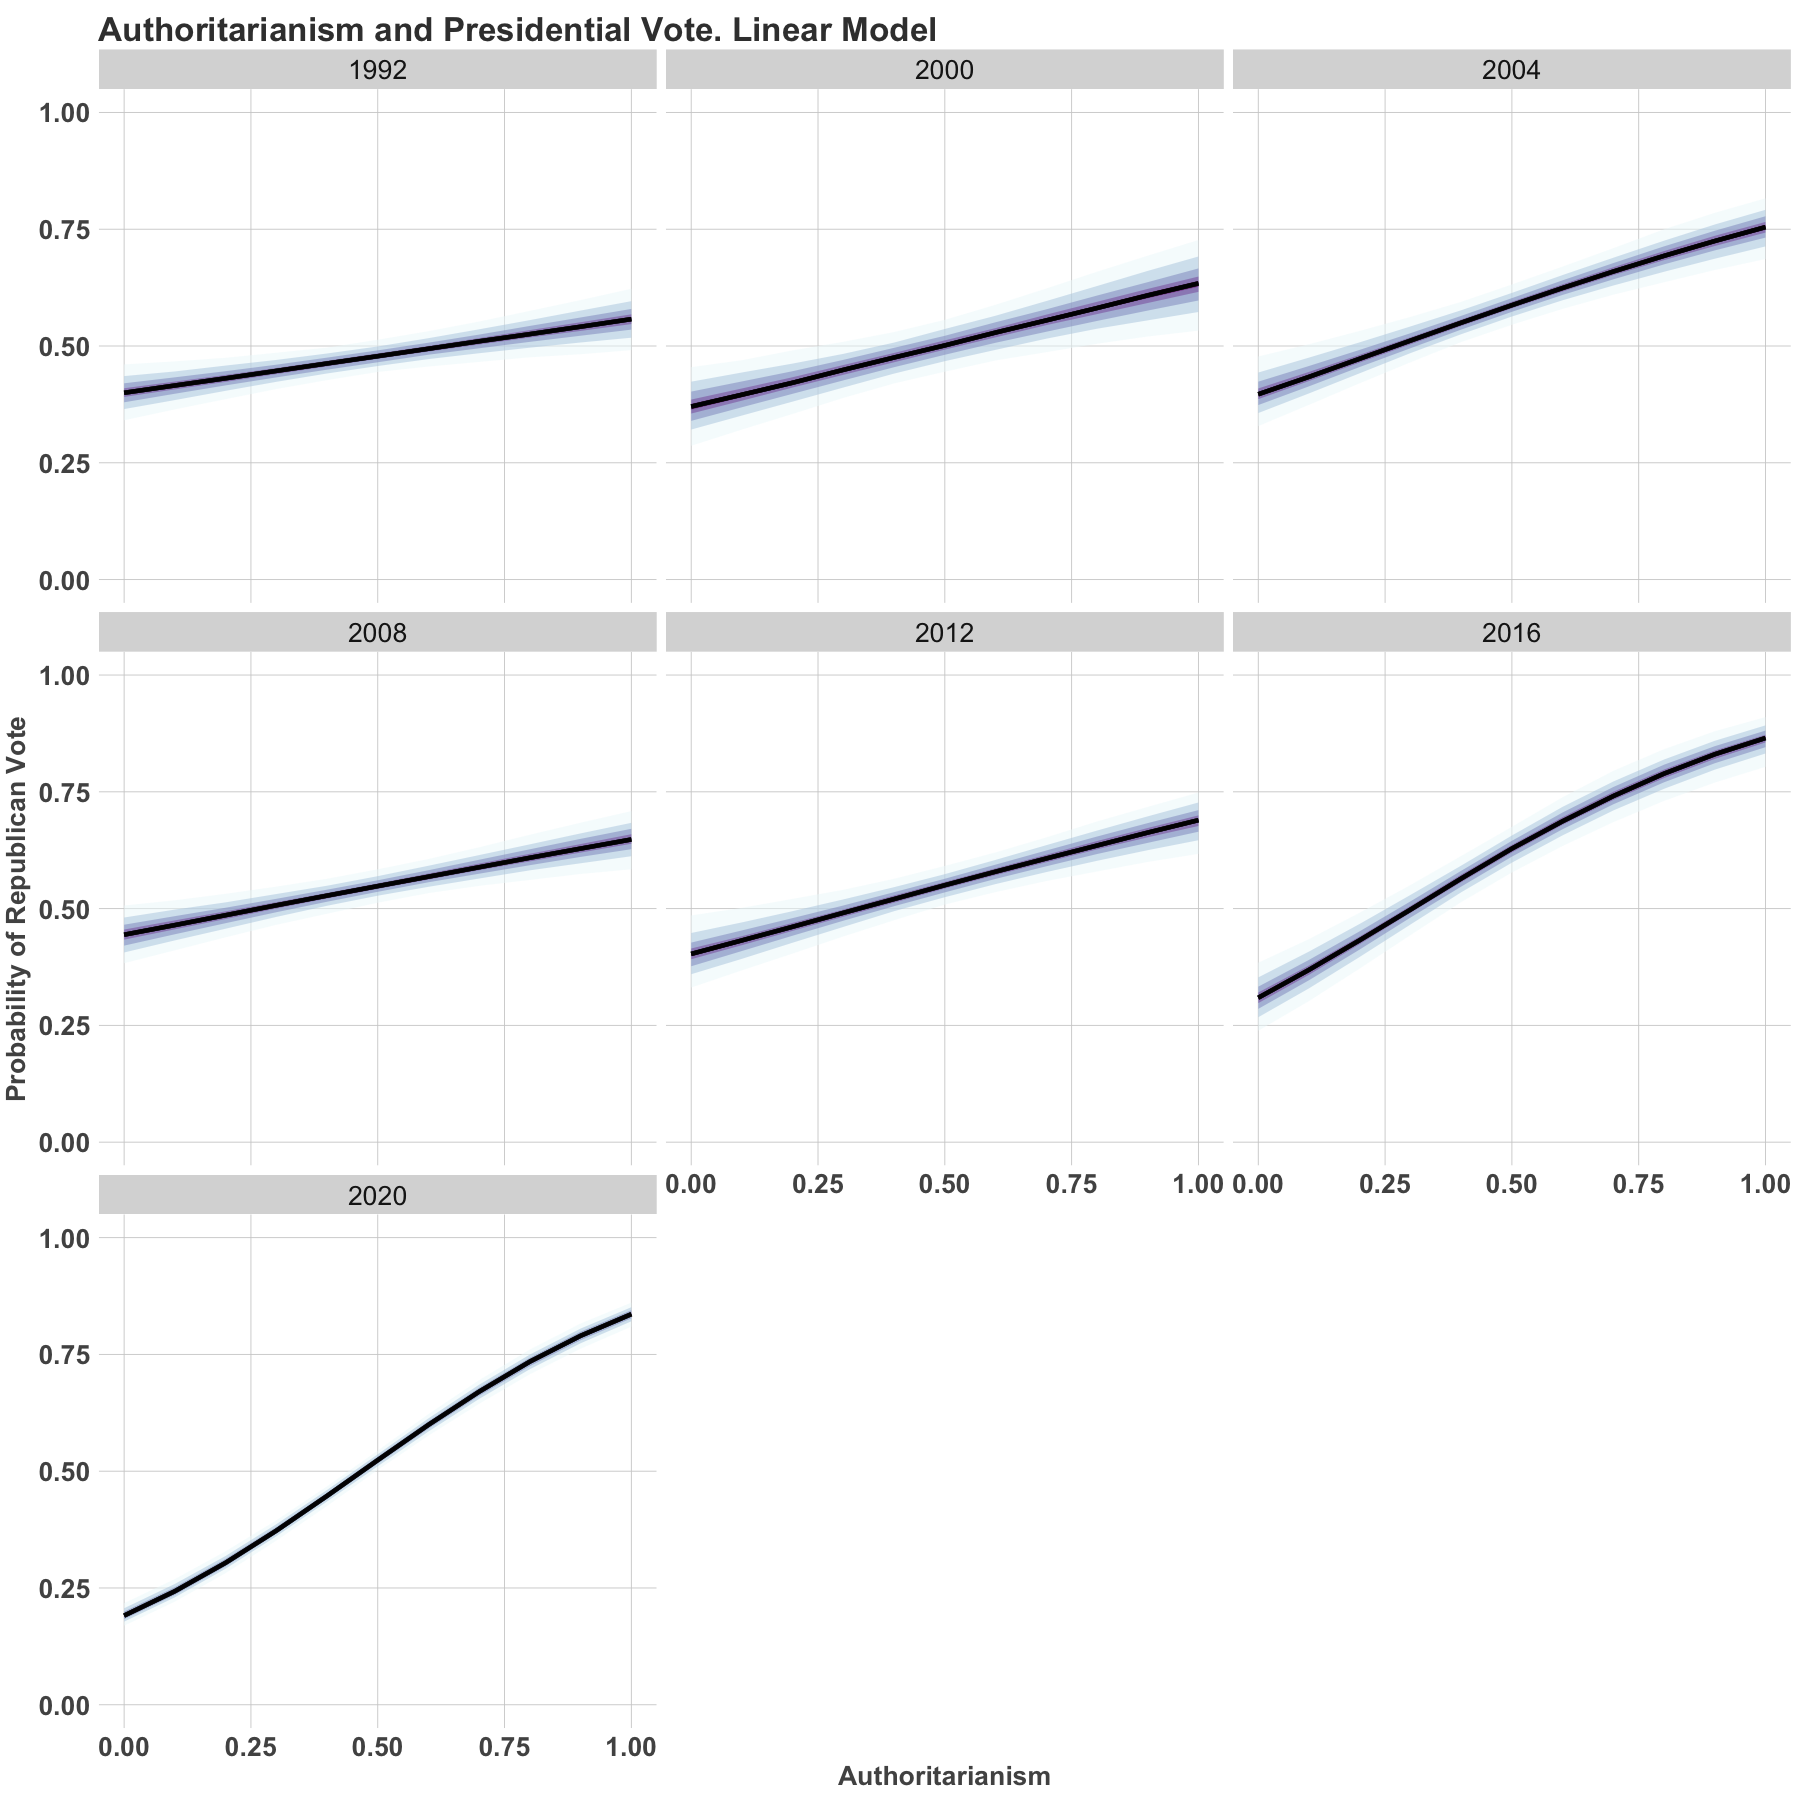

In [4]:
## Pull out the relevant models from my output.
fit0b = vote_models[[2]]
fit1  = vote_models[[3]]

## Expand the data used to estimate this model
fixed_data = data[,c("vote", "authoritarianism", 
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit() %>% 
                 mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = mean(college), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), authoritarianism = seq_range(authoritarianism, n = 11))  %>% 
                                                      mutate(authoritarianism_2 = authoritarianism*authoritarianism)
                                                      
          
m0 = fixed_data %>% add_linpred_draws(fit0b) %>%  mutate(Vote_Republican = plogis(.linpred))  ## Expand posterior

options(repr.plot.width=15, repr.plot.height=15)

## Plot linear Effects
 m0 %>% ggplot(aes(x = authoritarianism)) + facet_wrap(~year) + 
      stat_lineribbon(aes(y = Vote_Republican), .width = c(.95, 0.75, .5, 0.25, 0.1),  alpha = 0.5) +
       scale_fill_brewer(palette = 3)+
  # Format the grid
  ggtitle("Authoritarianism and Presidential Vote. Linear Model") +
  scale_y_continuous("Probability of Republican Vote", limits=c(0,1))+
  scale_x_continuous("Authoritarianism") + ggtheme +
  theme(legend.title = element_blank()) +
  theme(legend.position = "none") %>% suppressWarnings()
  


Here's the quadratic specification. This should serve as Figure 1 in Chapter 6.

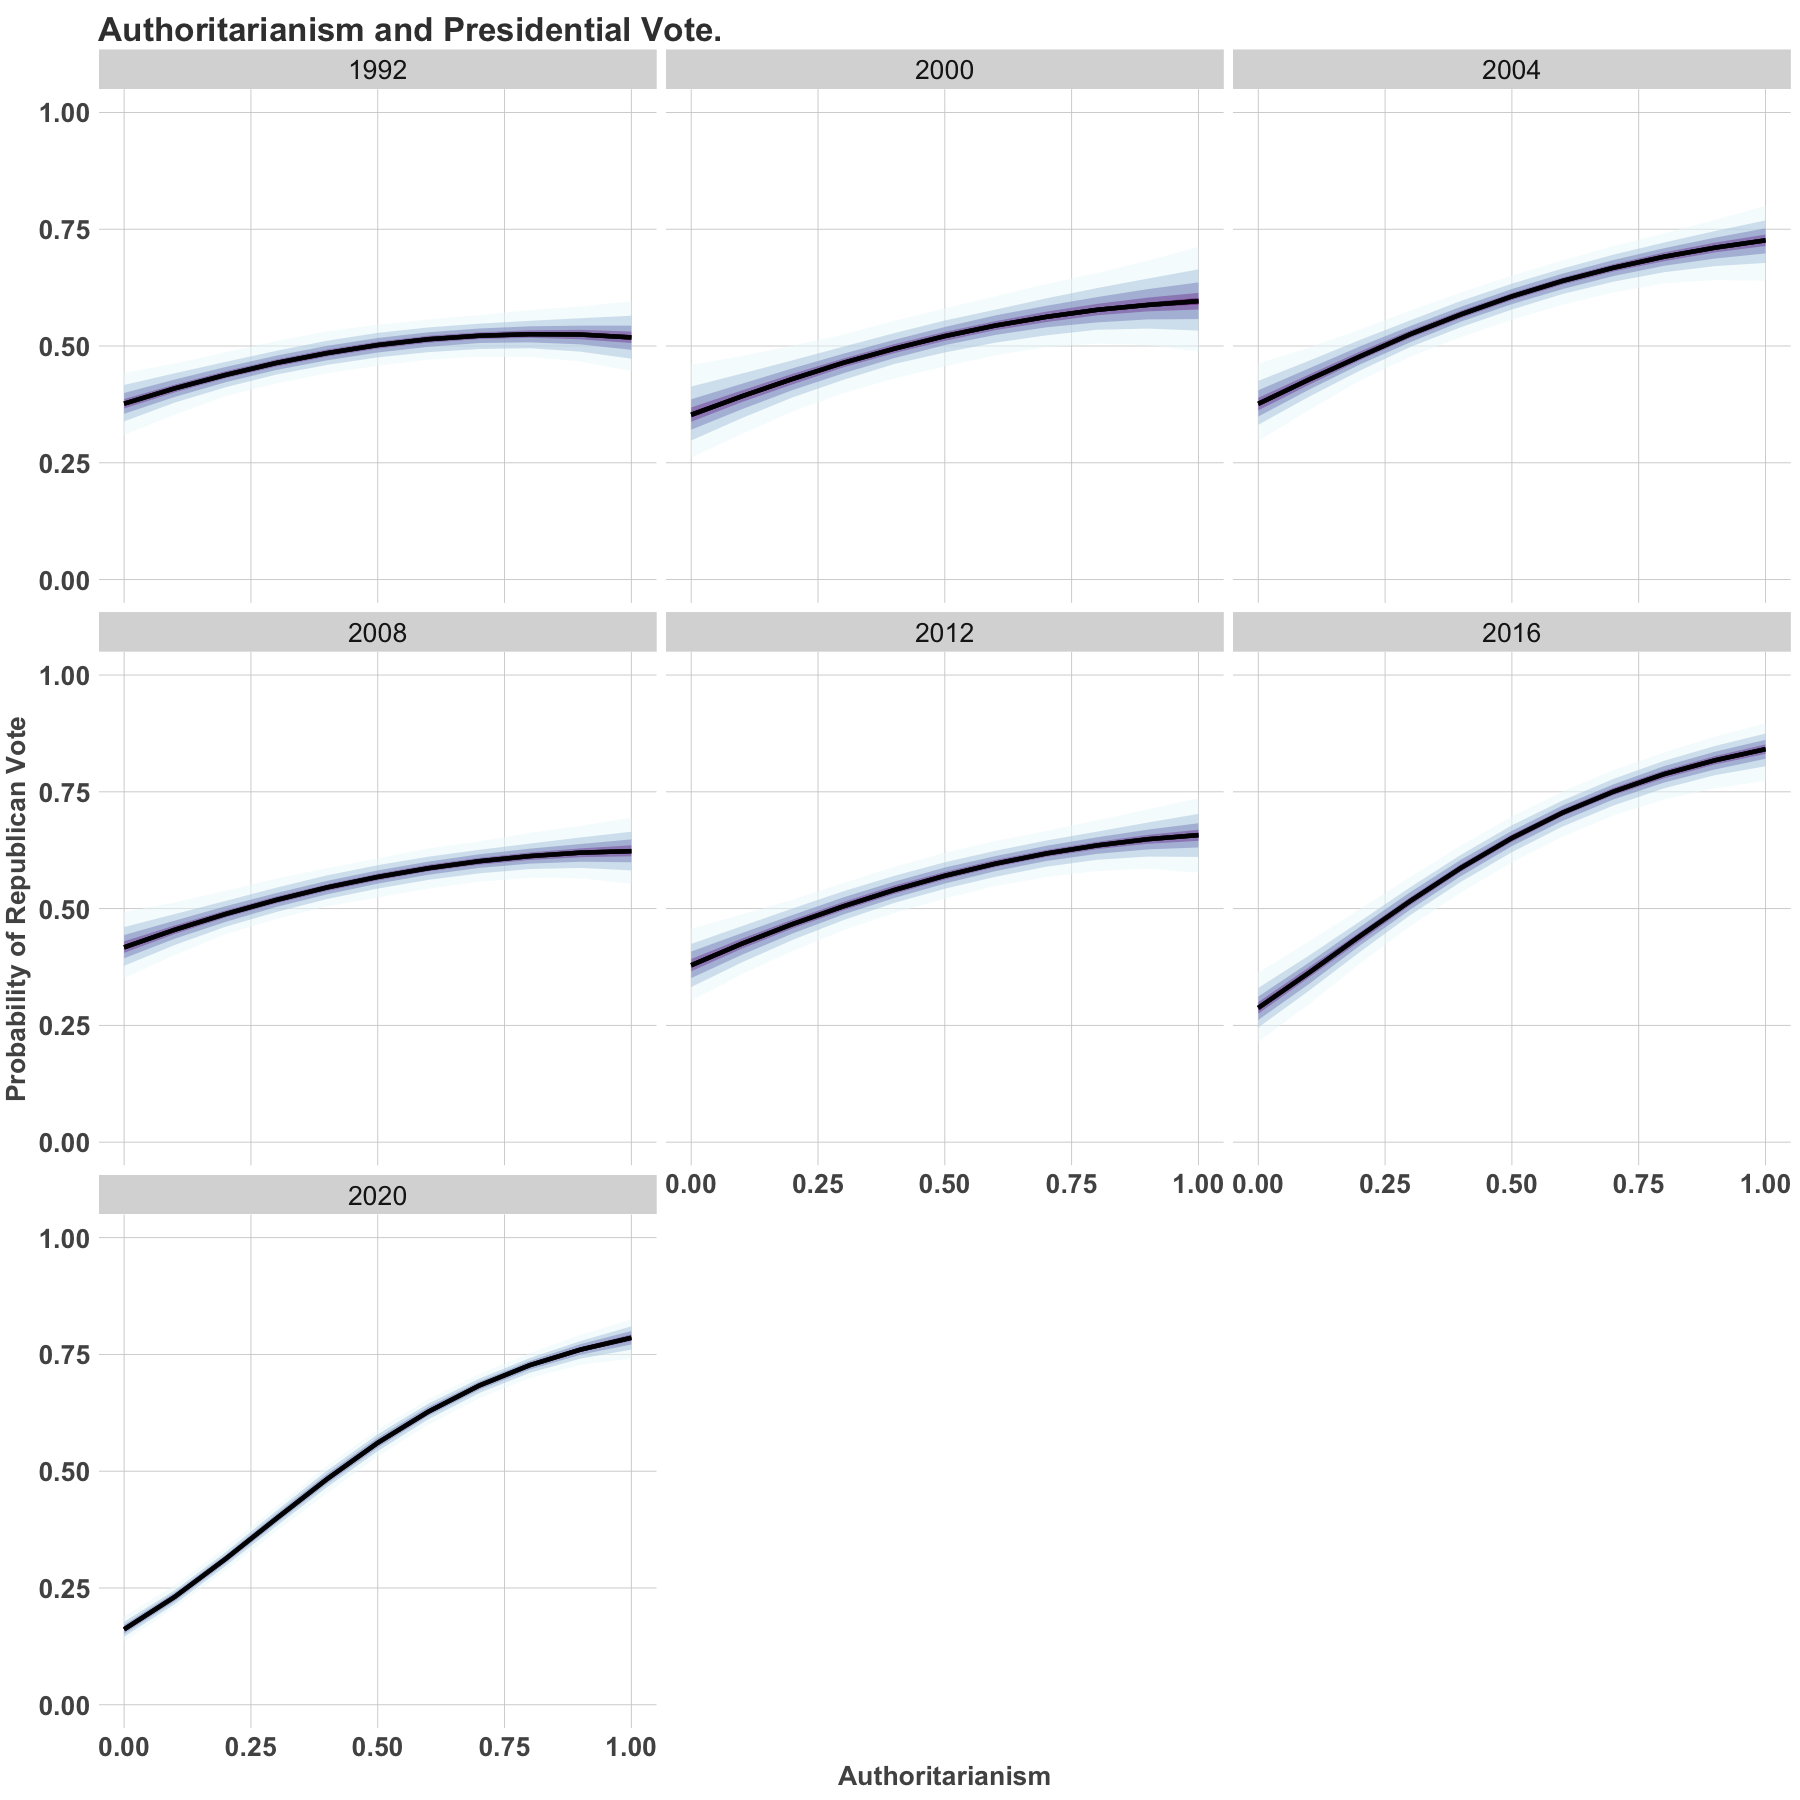

In [5]:
m1 = fixed_data %>% add_linpred_draws(fit1) %>%  mutate(Vote_Republican = plogis(.linpred))  ## Expand posterior

options(repr.plot.width=15, repr.plot.height=15)

## Plot linear Effects
 m1 %>% ggplot(aes(x = authoritarianism)) + facet_wrap(~year) + 
      stat_lineribbon(aes(y = Vote_Republican), .width = c(.95, 0.75, .5, 0.25, 0.1),  alpha = 0.5) +
       scale_fill_brewer(palette = 3)+
  # Format the grid
  ggtitle("Authoritarianism and Presidential Vote.") +
  scale_y_continuous("Probability of Republican Vote", limits=c(0,1))+
  scale_x_continuous("Authoritarianism") + ggtheme +
  theme(legend.title = element_blank()) +
  theme(legend.position = "none")
  


# Cross Validation

What model provides a better fit? A useful way to get at this -- due in part to the non-nested nature of the models -- is "leave-one-out" validation. Basically estimate the model on some subset of the data, predict the model on the "hold-out" data, and compare.  

In [375]:
# Generate an expanded dataset varying levels of authoritarianism at fixed covariates.
### linear model (fit0b) ###
fit0a = vote_models[[1]]
fit0b = vote_models[[2]]
fit1  = vote_models[[3]]

loo(fit0a, fit0b, fit1)

Output of model 'fit0a':

Computed from 1500 by 5983 log-likelihood matrix

         Estimate   SE
elpd_loo  -3754.5 26.8
p_loo        14.8  0.2
looic      7509.0 53.5
------
Monte Carlo SE of elpd_loo is 0.1.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

Output of model 'fit0b':

Computed from 1500 by 5983 log-likelihood matrix

         Estimate   SE
elpd_loo  -3685.1 28.7
p_loo        20.2  0.3
looic      7370.1 57.3
------
Monte Carlo SE of elpd_loo is 0.1.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

Output of model 'fit1':

Computed from 1500 by 5983 log-likelihood matrix

         Estimate   SE
elpd_loo  -3676.8 28.9
p_loo        22.9  0.4
looic      7353.6 57.8
------
Monte Carlo SE of elpd_loo is 0.1.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

Model comparisons:
      elpd_diff se_diff
fit1    0.0       0.0  
fit0b  -8.2       4.3  
fit0a -77.

The quadratic model is a reasonably good improvement over the lienar model (fit0b) and substantially better than the random-intercept, authoritarianism-has-a-fixed-effect model (fit0a).

# Marginal Effects

Below are the marginal effects. I'll show the linear effects, but throughout the remaining analysis, I just present the quadratic. As you can see here, there really isn't a large difference

### The Linear Variable Model

In [6]:
library(dplyr)
### Model to estimate AME
expanded_dat_0 = fixed_data %>% group_by(year) %>%       mutate(authoritarianism   =  quantile(authoritarianism, 0.025)) %>%
                                                      add_linpred_draws(fit0b, draws = 1000)   %>% 
                                                      mutate(low_auth = .linpred) 

expanded_dat_1 = fixed_data %>% group_by(year) %>%       mutate(authoritarianism =  quantile(authoritarianism, 0.975)) %>%
                                                      add_linpred_draws(fit0b, draws = 1000)   %>% 
                                                      mutate(high_auth = .linpred) %>% select(high_auth)

expanded_dat_0$high_auth = expanded_dat_1$high_auth
expanded_dat_0$marginal = plogis(expanded_dat_0$high_auth) -  plogis(expanded_dat_0$low_auth)

marginals = expanded_dat_0   %>% group_by(year) %>% mutate(min              = quantile(marginal, 0.025)) %>% 
                                        mutate(med              = quantile(marginal, 0.50)) %>% 
                                        mutate(max              = quantile(marginal, 0.975)) %>%   
                                        summarize(
                                            min = quantile(min, 0.025),
                                            med = quantile(med, 0.50),
                                            max = quantile(max, 0.975))
marginals

Adding missing grouping variables: `year`, `female`, `age`, `college`, `income`, `catholic`, `jewish`, `other`, `authoritarianism`, `authoritarianism_2`, `.row`


year,min,med,max
<dbl>,<dbl>,<dbl>,<dbl>
1992,0.04792691,0.1491353,0.2505729
2000,0.09380816,0.2502157,0.3899729
2004,0.22050578,0.3406553,0.4468286
2008,0.09130826,0.1951500,0.2870187
2012,0.15410865,0.2729135,0.3779595
2016,0.42140336,0.5327983,0.6346207
2020,0.57623964,0.6217558,0.6635904


### The Quadratic Variable Specification

In [7]:
### Model to estimate AME
expanded_dat_0 = fixed_data %>% group_by(year) %>%       mutate(authoritarianism   =  quantile(authoritarianism, 0.025)) %>%
                                                      mutate(authoritarianism_2 =  authoritarianism * authoritarianism) %>% data.frame() %>%
                                                      add_linpred_draws(fit1, draws = 1000)   %>% 
                                                      mutate(low_auth = .linpred) 

expanded_dat_1 = fixed_data %>% group_by(year) %>%       mutate(authoritarianism =  quantile(authoritarianism, 0.975)) %>%
                                                      mutate(authoritarianism_2 =  authoritarianism * authoritarianism) %>% data.frame() %>%
                                                      add_linpred_draws(fit1, draws = 1000)   %>% 
                                                      mutate(high_auth = .linpred) %>% select(high_auth)

expanded_dat_0$high_auth = expanded_dat_1$high_auth
expanded_dat_0$marginal = plogis(expanded_dat_0$high_auth) -  plogis(expanded_dat_0$low_auth)

marginals_q = expanded_dat_0   %>% group_by(year) %>% mutate(min              = quantile(marginal, 0.025)) %>% 
                                        mutate(med              = quantile(marginal, 0.50)) %>% 
                                        mutate(max              = quantile(marginal, 0.975)) %>%   
                                        summarize(
                                            min = quantile(min, 0.025),
                                            med = quantile(med, 0.50),
                                            max = quantile(max, 0.975))
marginals_q

Adding missing grouping variables: `year`, `female`, `age`, `college`, `income`, `catholic`, `jewish`, `other`, `authoritarianism`, `authoritarianism_2`, `.row`


year,min,med,max
<dbl>,<dbl>,<dbl>,<dbl>
1992,0.03533232,0.1329992,0.2328557
2000,0.07749971,0.2299629,0.3801666
2004,0.20974759,0.3329866,0.4377701
2008,0.09506544,0.1957390,0.2891884
2012,0.14733244,0.2653167,0.3788416
2016,0.42161527,0.5299153,0.6274290
2020,0.55654079,0.6021737,0.6460856


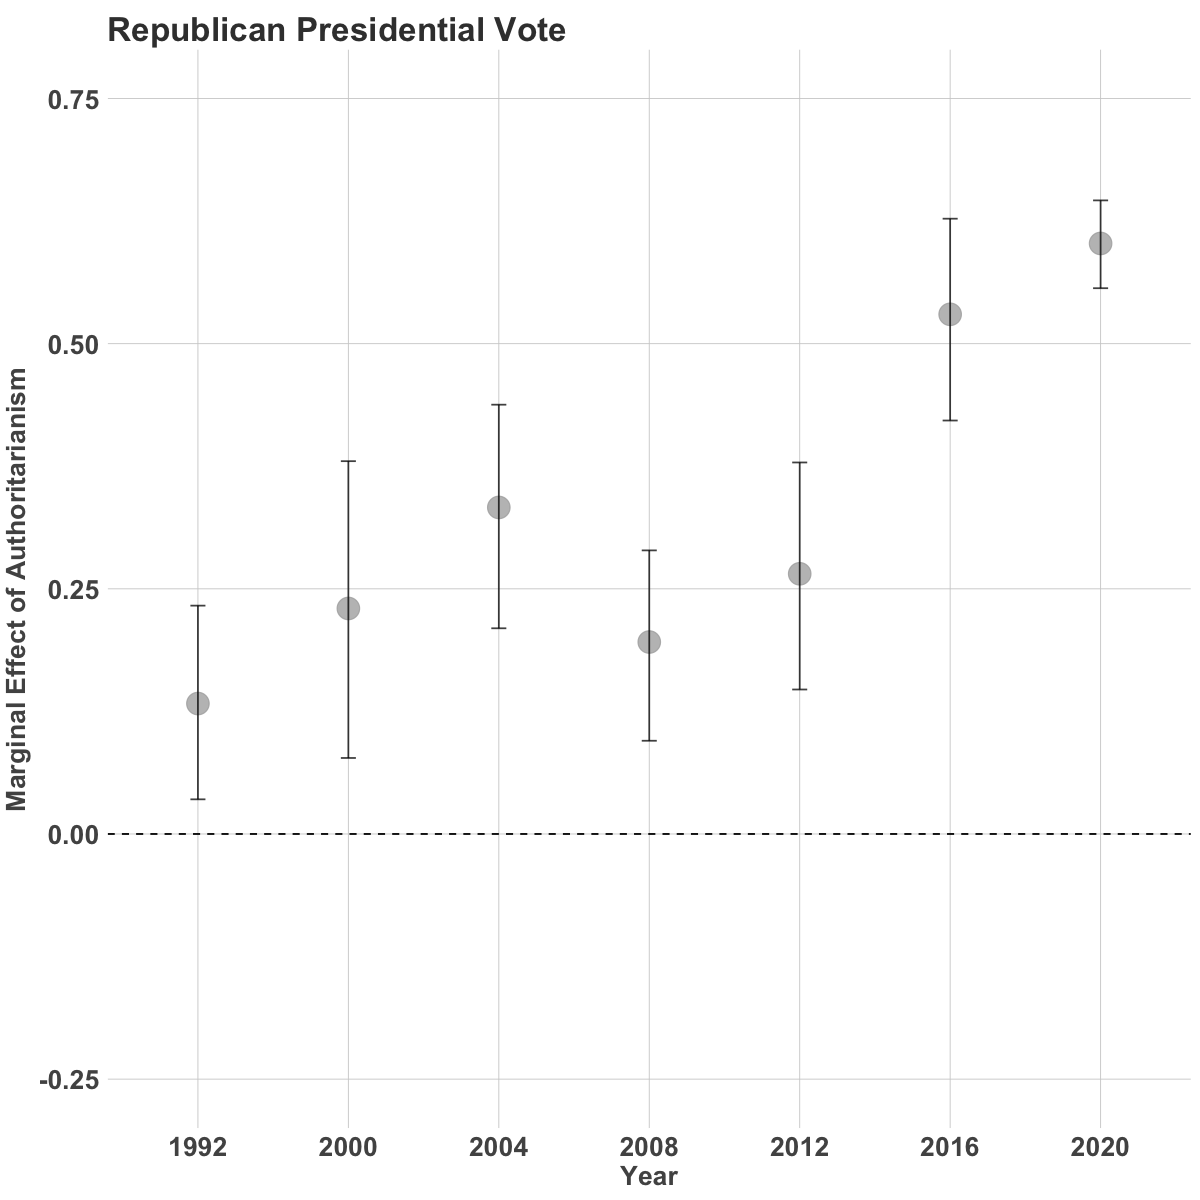

In [8]:
## Marginal Efffects plot for quadratic
options(repr.plot.width=10, repr.plot.height=10)
ggplot(data = marginals_q,
              aes(x = factor(year), 
                  y = med, ymin=max, 
                  ymax=min))+
  geom_point(size=6, colour = "darkgrey", alpha = 0.75) +
  geom_errorbar(width = 0.10, alpha=0.75, colour = "black") +
  ggtitle("Republican Presidential Vote") +
  ggtheme + 
  scale_y_continuous("Marginal Effect of Authoritarianism", limits=c(-.25,0.75))+
  scale_x_discrete("Year") + 
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") 

This figure forms Figure 2 in the chapter.

## Education x Authoritarianism 

Here are the effects disaggregated by education. Some of it is new, and I think the marginal effect plot is particularly useful.

In [95]:
## Marginal Effects Function -- adapt to more complicated interactions
library(dplyr)
fixed = data[,c("vote", "authoritarianism", 
            "female", "age", "college", "income",
            "jewish", "catholic", "other", "year")] %>% na.omit() %>% 
              mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
              na.omit()
marginal_by_ed = function(fixed = fixed, model_fit = education){
                        out1 = fixed %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                                                                            college = c(0,1) , income = mean(income), 
                                                                                                            catholic =  mean(catholic), jewish = mean(jewish), 
                                                                                                            other = mean(other),  authoritarianism = quantile(authoritarianism, 0.025)) %>% 
                                                                                                            mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>% 
                                                                                                            add_epred_draws(model_fit, ndraws = 100) %>% subset(select = .epred) 

                        out2 =  fixed %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                                                                            college = c(0,1), income = mean(income), 
                                                                                                            catholic =  mean(catholic), jewish = mean(jewish), 
                                                                                                            other = mean(other),  authoritarianism = quantile(authoritarianism,.975)) %>% 
                                                                                                            mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>% 
                                                                                                            add_epred_draws(model_fit, ndraws = 100) %>% subset(select = .epred) 

                        r = fixed %>% na.omit() %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                                                                            college = c(0,1), income = mean(income), 
                                                                                                            catholic =  mean(catholic), jewish = mean(jewish), 
                                                                                                            other = mean(other),  
                                                                                                            authoritarianism = quantile(authoritarianism, 0.025))%>% 
                                                                                                            mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>% 
                                                                                                            add_epred_draws(model_fit, ndraws = 100) 
                        r$marginal = out2$.epred - out1$.epred 
                        return(r)
                        }


`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.


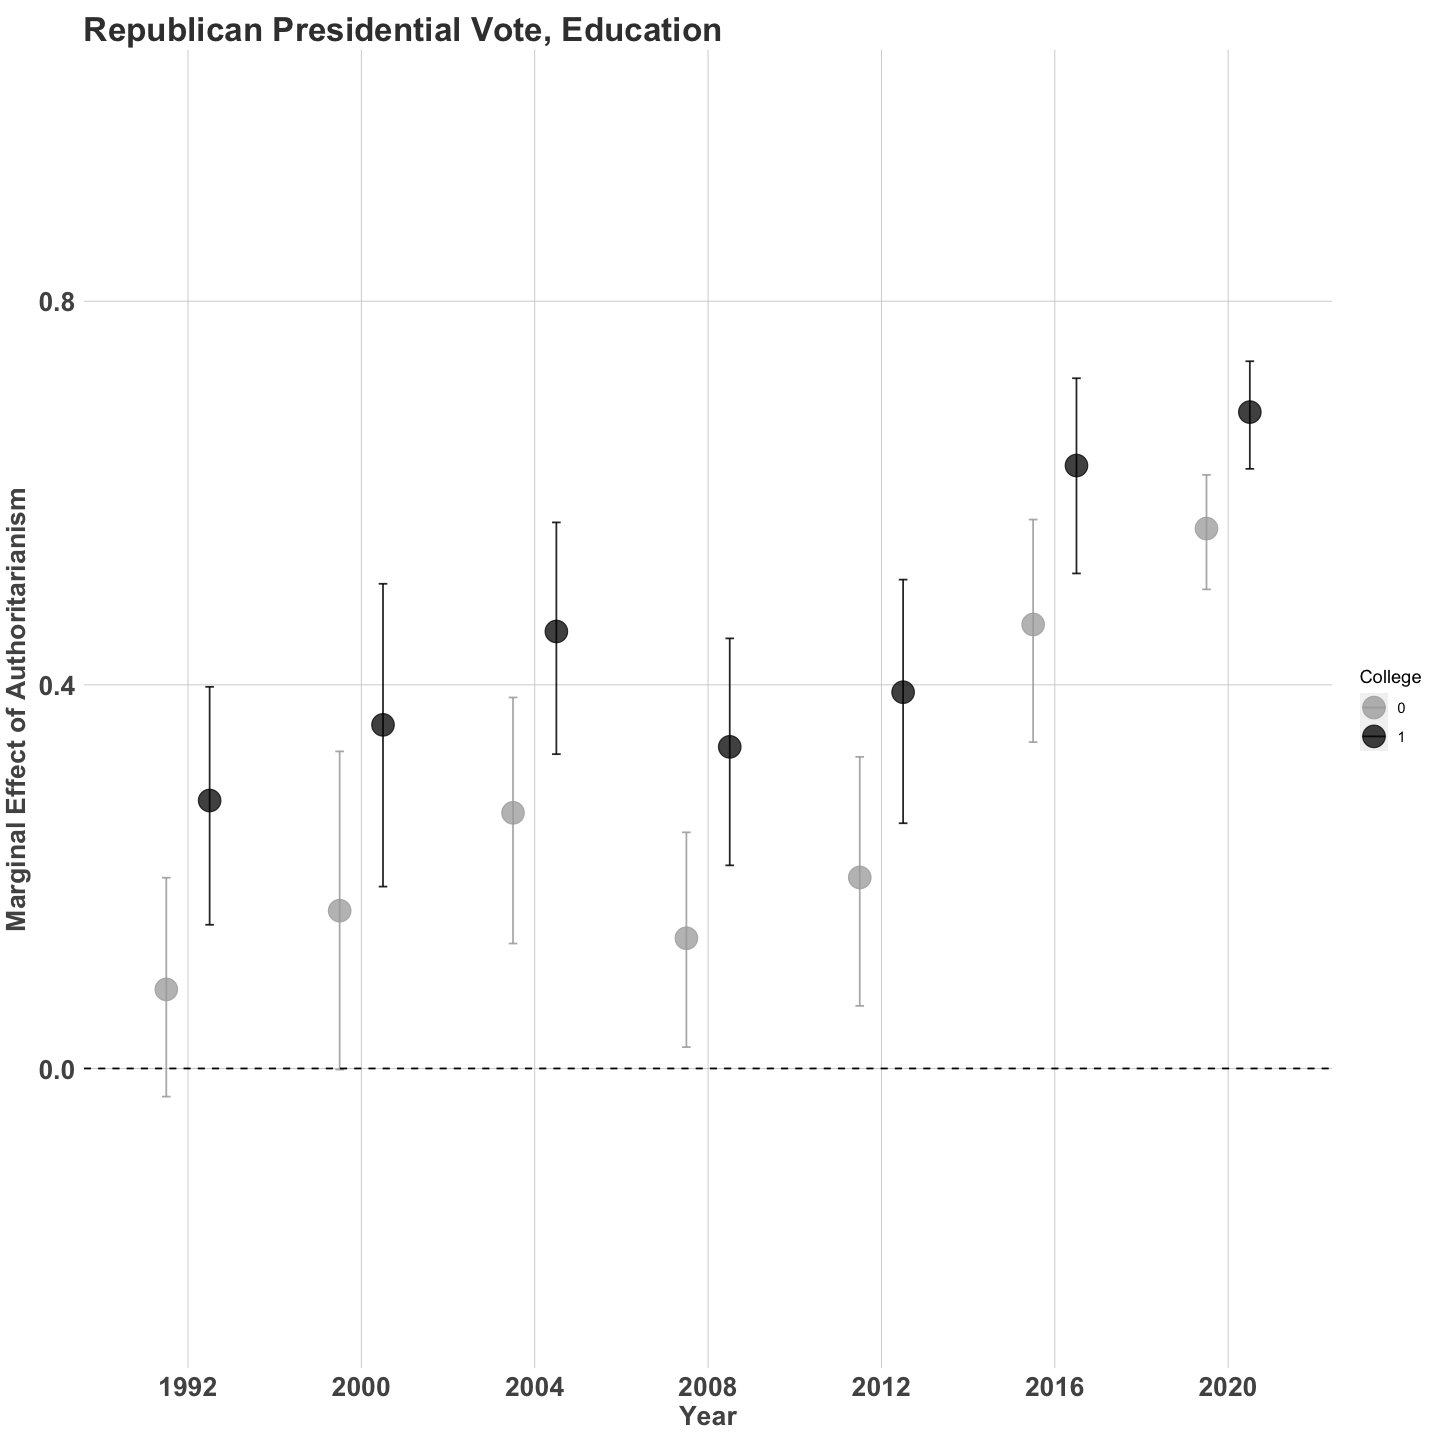

In [96]:
education  = vote_models[[4]]

marginal_by_ed(fixed = fixed)  %>% group_by(year, college) %>% 
                                        mutate(min              = quantile(marginal, 0.025)) %>% 
                                        mutate(med              = quantile(marginal, 0.50)) %>% 
                                        mutate(max              = quantile(marginal, 0.975)) %>%   
                                        summarize(
                                            min = quantile(min, 0.025),
                                            med = quantile(med, 0.50),
                                            max = quantile(max, 0.975)) %>% 
ggplot(aes(x = factor(year), 
                  y = med, ymin=max, 
                  ymax=min, colour = as.factor(college), group = as.factor(college)))+
  geom_point(size=6,  alpha = 0.75, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.10, alpha=0.85, position = position_dodge(width = 0.5)) +
  ggtitle("Republican Presidential Vote, Education") +
  ggtheme + 
  scale_y_continuous("Marginal Effect of Authoritarianism", limits=c(-0.25,1)) + 
  scale_x_discrete("Year") + 
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  scale_colour_manual(name="College", values=c("darkgrey", "black"))

In [ ]:
marginal_by_ed(fixed = fixed)  %>% group_by(year, college) %>% 
                                        mutate(min              = quantile(marginal, 0.025)) %>% 
                                        mutate(med              = quantile(marginal, 0.50)) %>% 
                                        mutate(max              = quantile(marginal, 0.975)) %>%   
                                        summarize(
                                            min = quantile(min, 0.025),
                                            med = quantile(med, 0.50),
                                            max = quantile(max, 0.975)) %>% 
ggplot(aes(x = factor(year), 
                  y = med, ymin=max, 
                  ymax=min, colour = as.factor(college), group = as.factor(college)))+
  geom_point(size=6,  alpha = 0.75, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.10, alpha=0.85, position = position_dodge(width = 0.5)) +
  ggtitle("Republican Presidential Vote, Education") +
  ggtheme + 
  scale_y_continuous("Marginal Effect of Authoritarianism", limits=c(-0.25,1)) + 
  scale_x_discrete("Year") + 
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  scale_colour_manual(name="College", values=c("darkgrey", "black"))

Here is the predictive plot. We probably don't need to present this, but just in case....

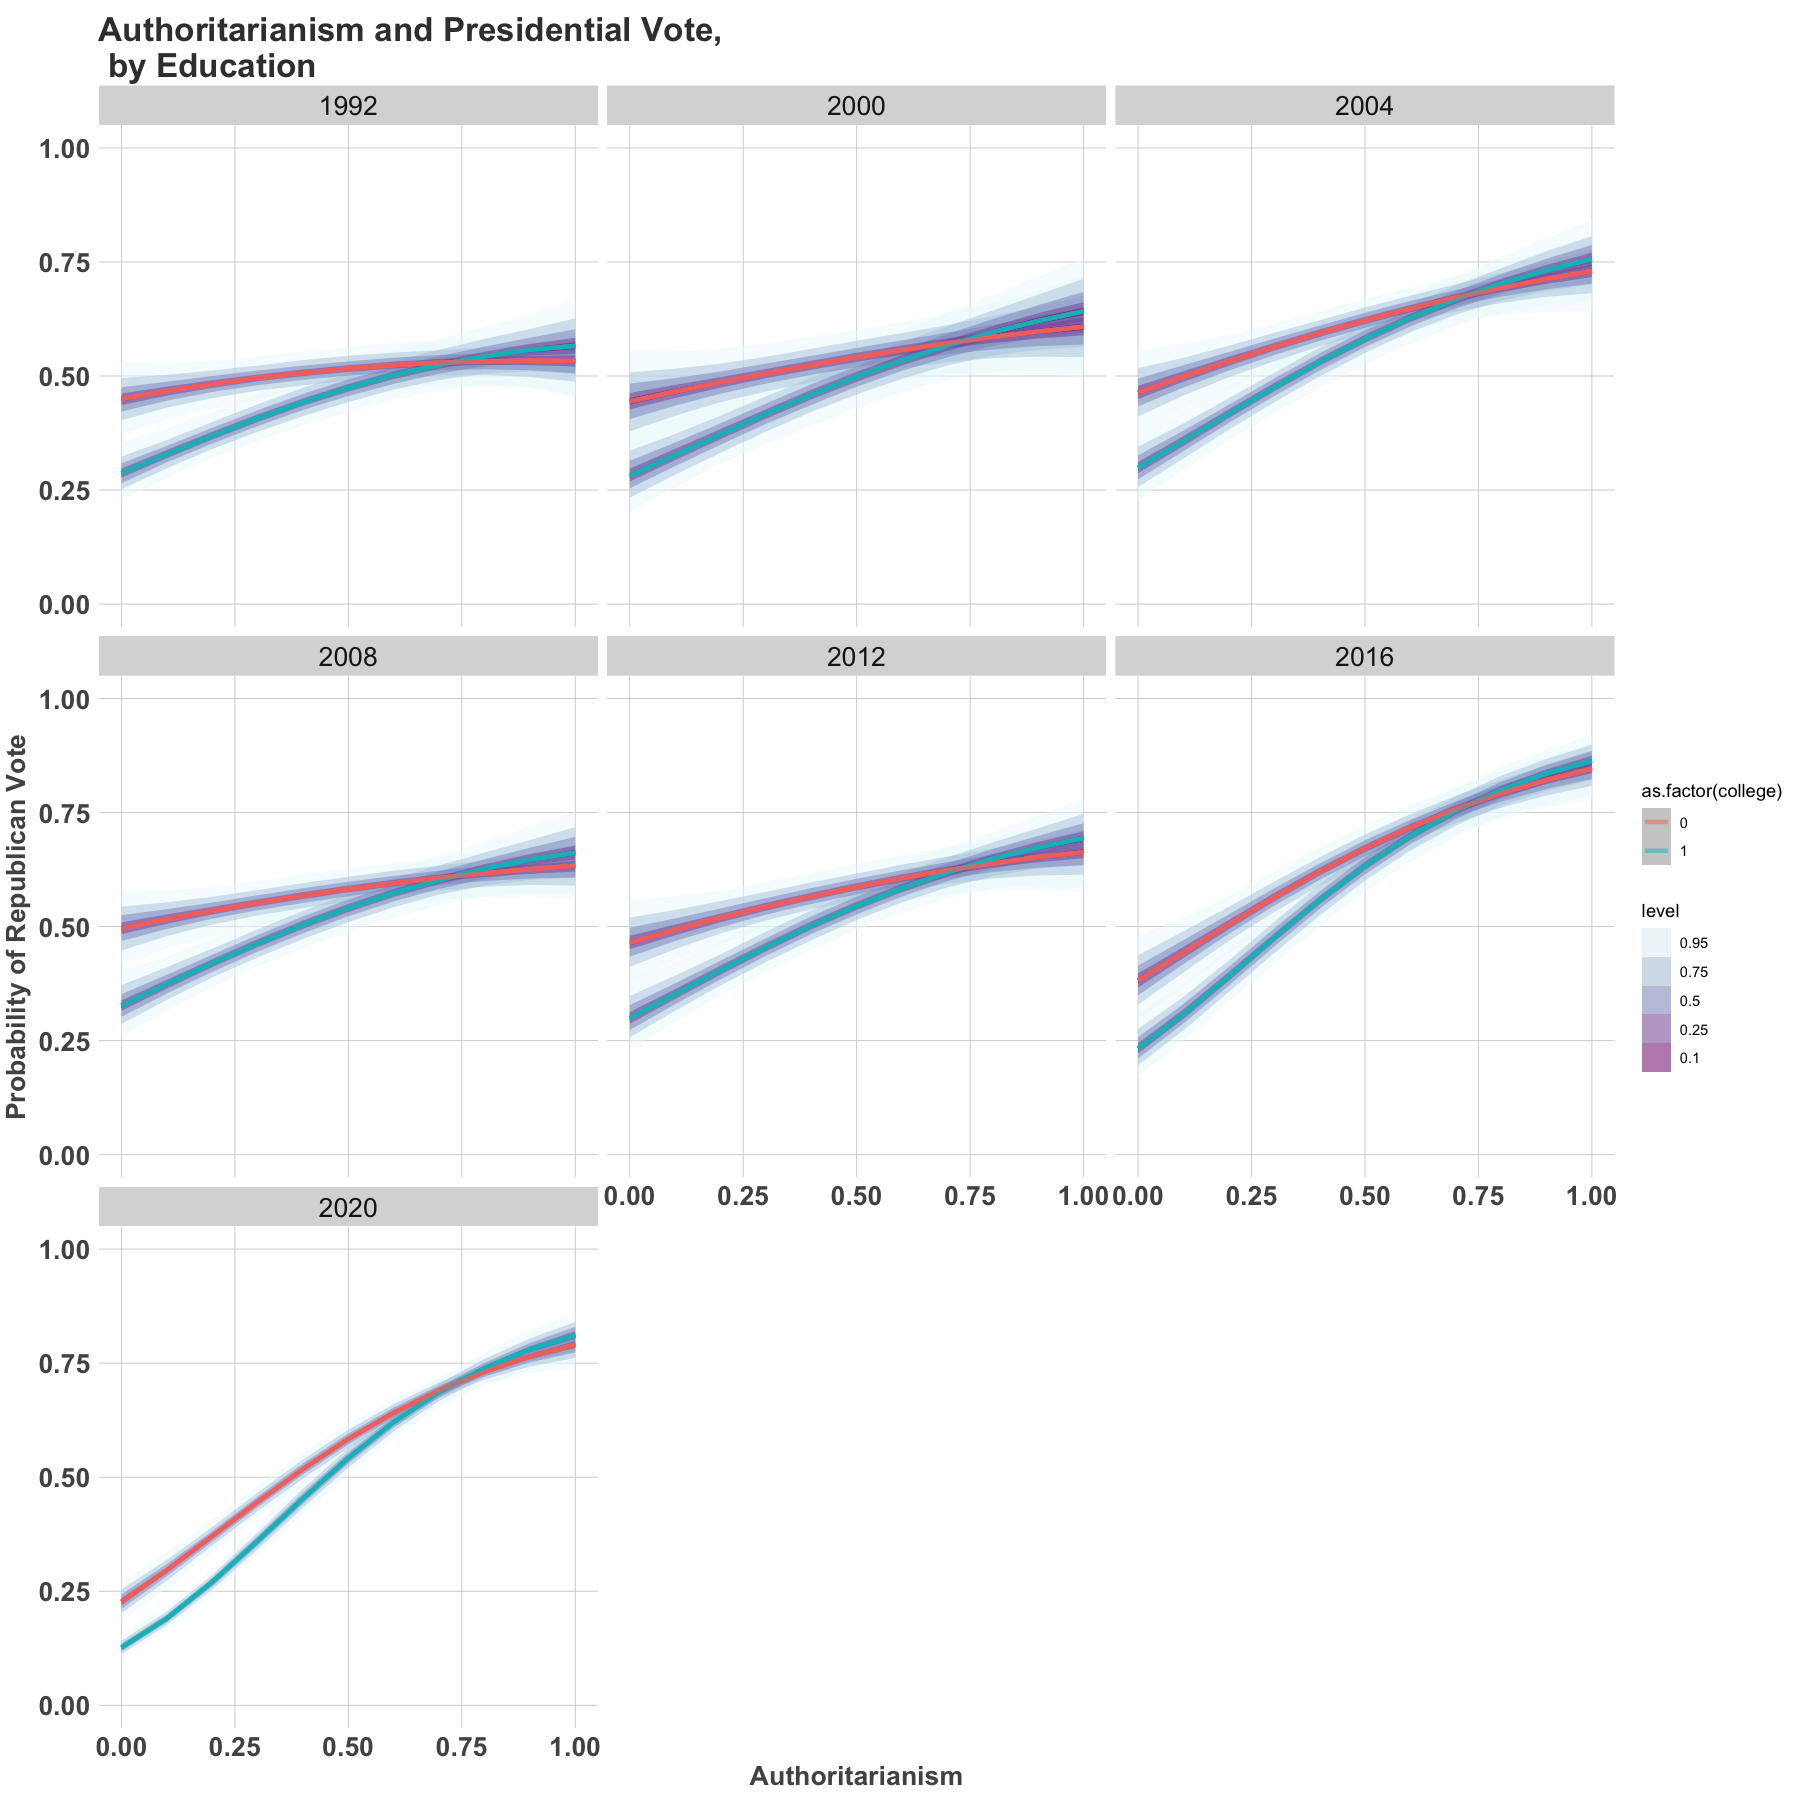

In [13]:
education  = vote_models[[4]]

fixed_data = data[,c("vote", "authoritarianism", 
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit() %>% 
                 mutate(authoritarianism_2 = authoritarianism*authoritarianism) 
                   
model1 = fixed_data %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = c(0,1), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), 
                                                      authoritarianism = seq_range(authoritarianism, n = 11)) %>%   
                                                      mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%  
                                                      group_by(year) %>%
                                                      add_linpred_draws(education) %>% 
                                                      mutate(Vote_Republican = plogis(.linpred))   
          
          
 options(repr.plot.width=15, repr.plot.height=15)
                                         
model1 %>%  ggplot(aes(x = authoritarianism, group = college, colour = as.factor(college))) + facet_wrap(~year) + 
      stat_lineribbon(aes(y = Vote_Republican), .width = c(.95, 0.75, .5, 0.25, 0.1),  alpha = 0.5) +
      scale_fill_brewer(palette = 3)+ ggtheme +
  # Format the grid
  ggtitle("Authoritarianism and Presidential Vote,\n by Education") +
  scale_y_continuous("Probability of Republican Vote", limits=c(0,1))+
  scale_x_continuous("Authoritarianism")                                                        
                                                                        


# Affective Polarization

Here are the bar plots for our affective analysis plots (Figures 3,4)

`summarise()` has grouped output by '.group', 'Authoritarianism'. You can override using the `.groups` argument.


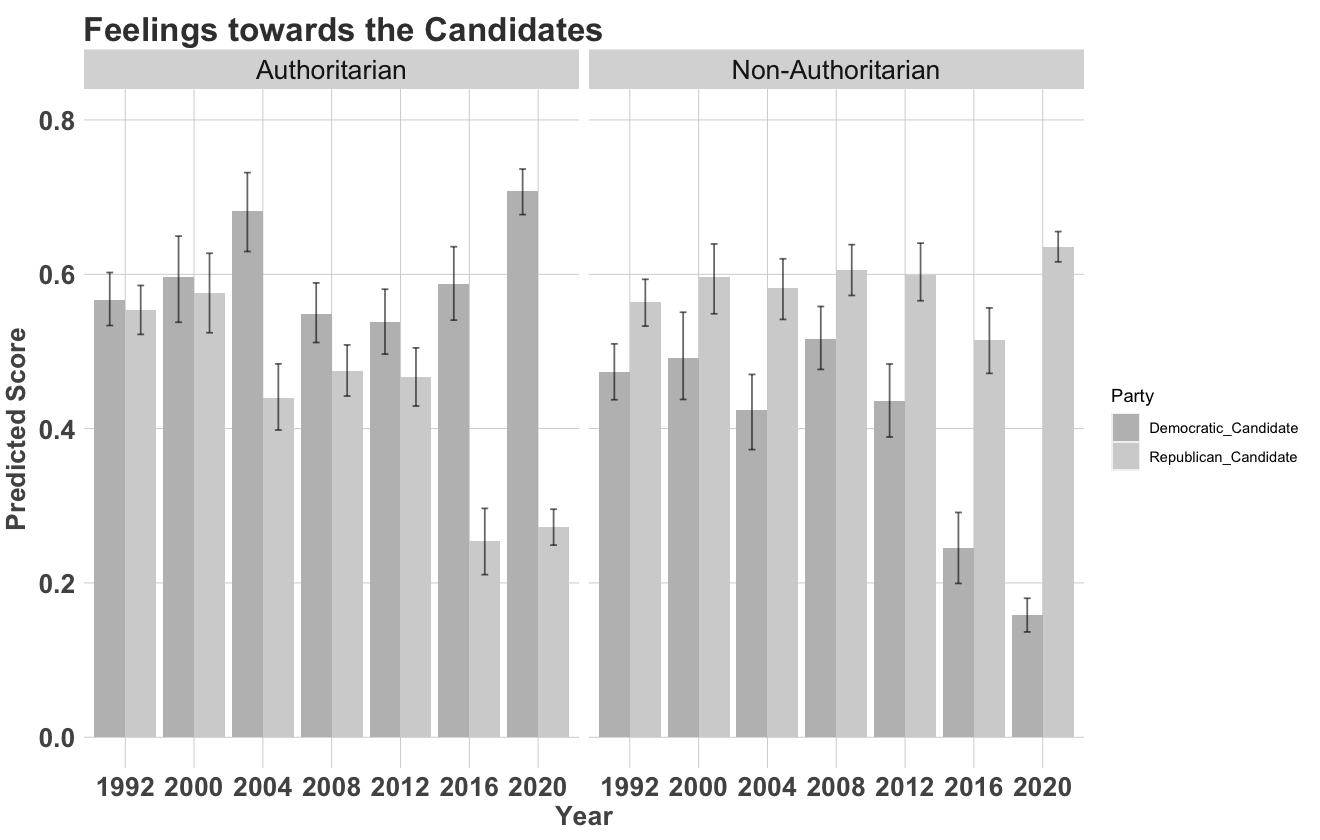

In [62]:
reps = affect[[1]]
dems = affect[[2]]
repc = affect[[3]]
demc = affect[[4]]
                   
fixed_data = data[,c("party3", "authoritarianism", 
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit() %>% 
                 mutate(authoritarianism_2 = authoritarianism*authoritarianism)  %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = mean(college), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), 
                                                      authoritarianism = seq_range(authoritarianism, n = 2)) %>%   
                                                      mutate(authoritarianism_2 = authoritarianism*authoritarianism)   

data.frame(rbind( fixed_data  %>% add_linpred_draws(reps, draws = 1000)   %>% mutate(.group = "Republicans"),
                              fixed_data  %>% add_linpred_draws(dems, draws = 1000)   %>% mutate(.group = "Democrats"),
                              fixed_data  %>% add_linpred_draws(repc, draws = 1000)   %>% mutate(.group = "Republican_Candidate"),
                              fixed_data  %>% add_linpred_draws(demc, draws = 1000)   %>% mutate(.group = "Democratic_Candidate"))) %>% 
                               mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                                group_by(.group, Authoritarianism, year) %>% 
                                summarise(mean = quantile(.linpred, prob =0.5),
                                          min  = quantile(.linpred, prob =0.025),
                                          max  = quantile(.linpred, prob =0.975)  
                                ) %>% as_tibble() %>% filter(.group %in% c("Democratic_Candidate", "Republican_Candidate")) %>%                                 
                                ggplot(aes(x = as.factor(year), ymin = min, ymax = max, y=mean,  fill =.group), stat="identity", position=position_dodge()) + 
                                geom_bar(stat="identity", position=position_dodge())+
                                scale_fill_manual(name="Party", values=c("gray", "lightgray"))+
                                geom_errorbar(width=.2, position=position_dodge(0.9), alpha = 0.6) +
                                 facet_wrap(~Authoritarianism)+ggtitle("Feelings towards the Candidates") +
                                 scale_y_continuous("Predicted Score", limits=c(0, 0.8)) +ggtheme +
                                 scale_x_discrete("Year")

`summarise()` has grouped output by '.group', 'Authoritarianism'. You can override using the `.groups` argument.


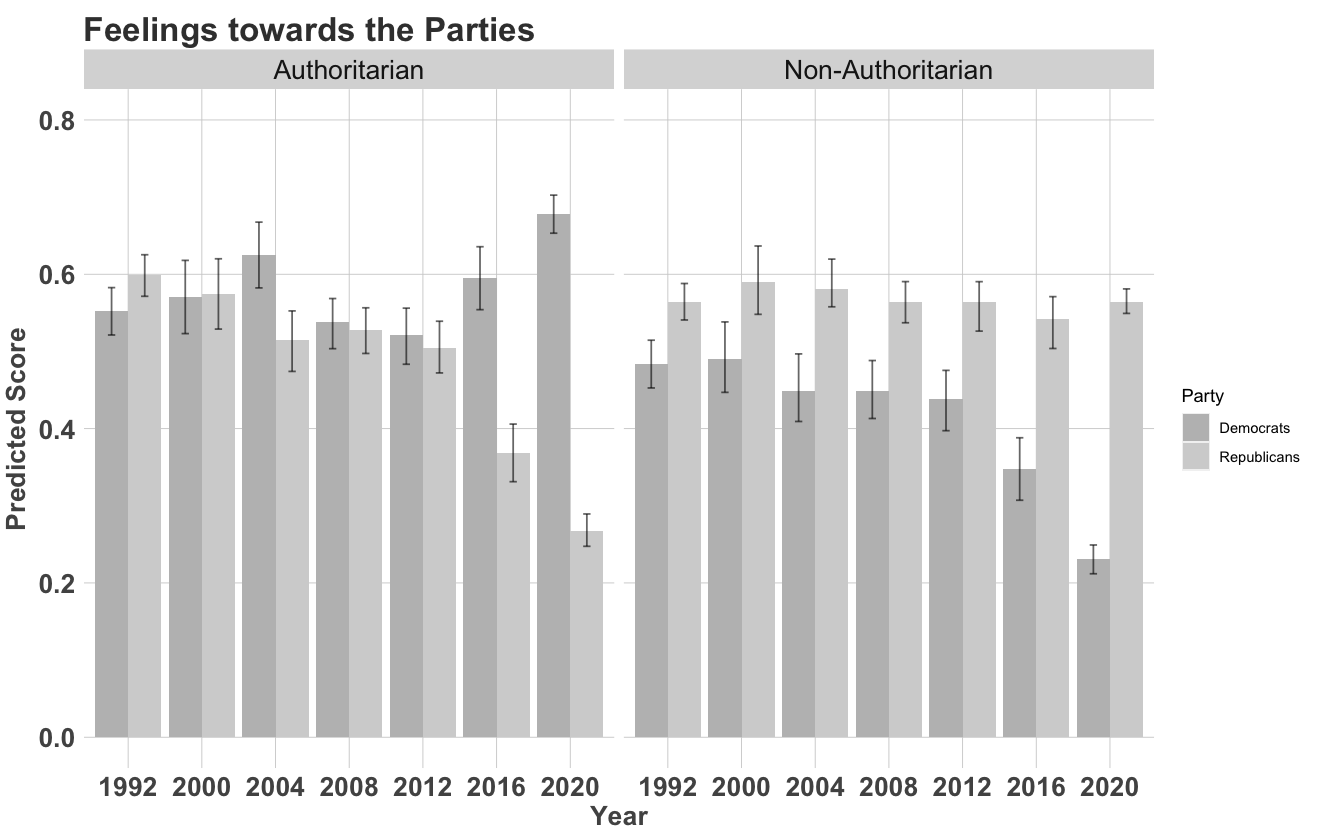

In [63]:
data.frame(rbind( fixed_data  %>% add_linpred_draws(reps, draws = 1000)   %>% mutate(.group = "Republicans"),
                              fixed_data  %>% add_linpred_draws(dems, draws = 1000)   %>% mutate(.group = "Democrats"),
                              fixed_data  %>% add_linpred_draws(repc, draws = 1000)   %>% mutate(.group = "Republican_Candidate"),
                              fixed_data  %>% add_linpred_draws(demc, draws = 1000)   %>% mutate(.group = "Democratic_Candidate"))) %>% 
                               mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                                group_by(.group, Authoritarianism, year) %>% 
                                summarise(mean = quantile(.linpred, prob =0.5),
                                          min  = quantile(.linpred, prob =0.025),
                                          max  = quantile(.linpred, prob =0.975)  
                                ) %>% as_tibble() %>% filter(.group %in% c("Democrats", "Republicans")) %>%                                 
                                ggplot(aes(x = as.factor(year), ymin = min, ymax = max, y=mean,  fill =.group), stat="identity", position=position_dodge()) + 
                                geom_bar(stat="identity", position=position_dodge())+
                                scale_fill_manual(name="Party", values=c("gray", "lightgray"))+
                                geom_errorbar(width=.2, position=position_dodge(0.9), alpha = 0.6) +
                                 facet_wrap(~Authoritarianism)+ggtitle("Feelings towards the Parties") +
                                 scale_y_continuous("Predicted Score", limits=c(0, 0.8)) +ggtheme +
                                 scale_x_discrete("Year")

In [73]:
## Write a function to calculate margins, main effects
margins = function(fixed = fixed, model_fit){
                        out1 = fixed %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                                                                            college = mean(college) , income = mean(income), 
                                                                                                            catholic =  mean(catholic), jewish = mean(jewish), 
                                                                                                            other = mean(other),  authoritarianism = min(authoritarianism) ) %>% 
                                                                                                            mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>% 
                                                                                                            add_epred_draws(model_fit, ndraws = 100) %>% subset(select = .epred) 

                        out2 =  fixed %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                                                                            college = mean(college), income = mean(income), 
                                                                                                            catholic =  mean(catholic), jewish = mean(jewish), 
                                                                                                            other = mean(other),  authoritarianism = max(authoritarianism) ) %>% 
                                                                                                            mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>% 
                                                                                                            add_epred_draws(model_fit, ndraws = 100) %>% subset(select = .epred) 

                        r = fixed %>% na.omit() %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                                                                            college = mean(college), income = mean(income), 
                                                                                                            catholic =  mean(catholic), jewish = mean(jewish), 
                                                                                                            other = mean(other),  
                                                                                                            authoritarianism = 0 )%>% 
                                                                                                            mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>% 
                                                                                                            add_epred_draws(model_fit, ndraws = 100) 
                        r$marginal = out2$.epred - out1$.epred 
                        return(r)
                        }

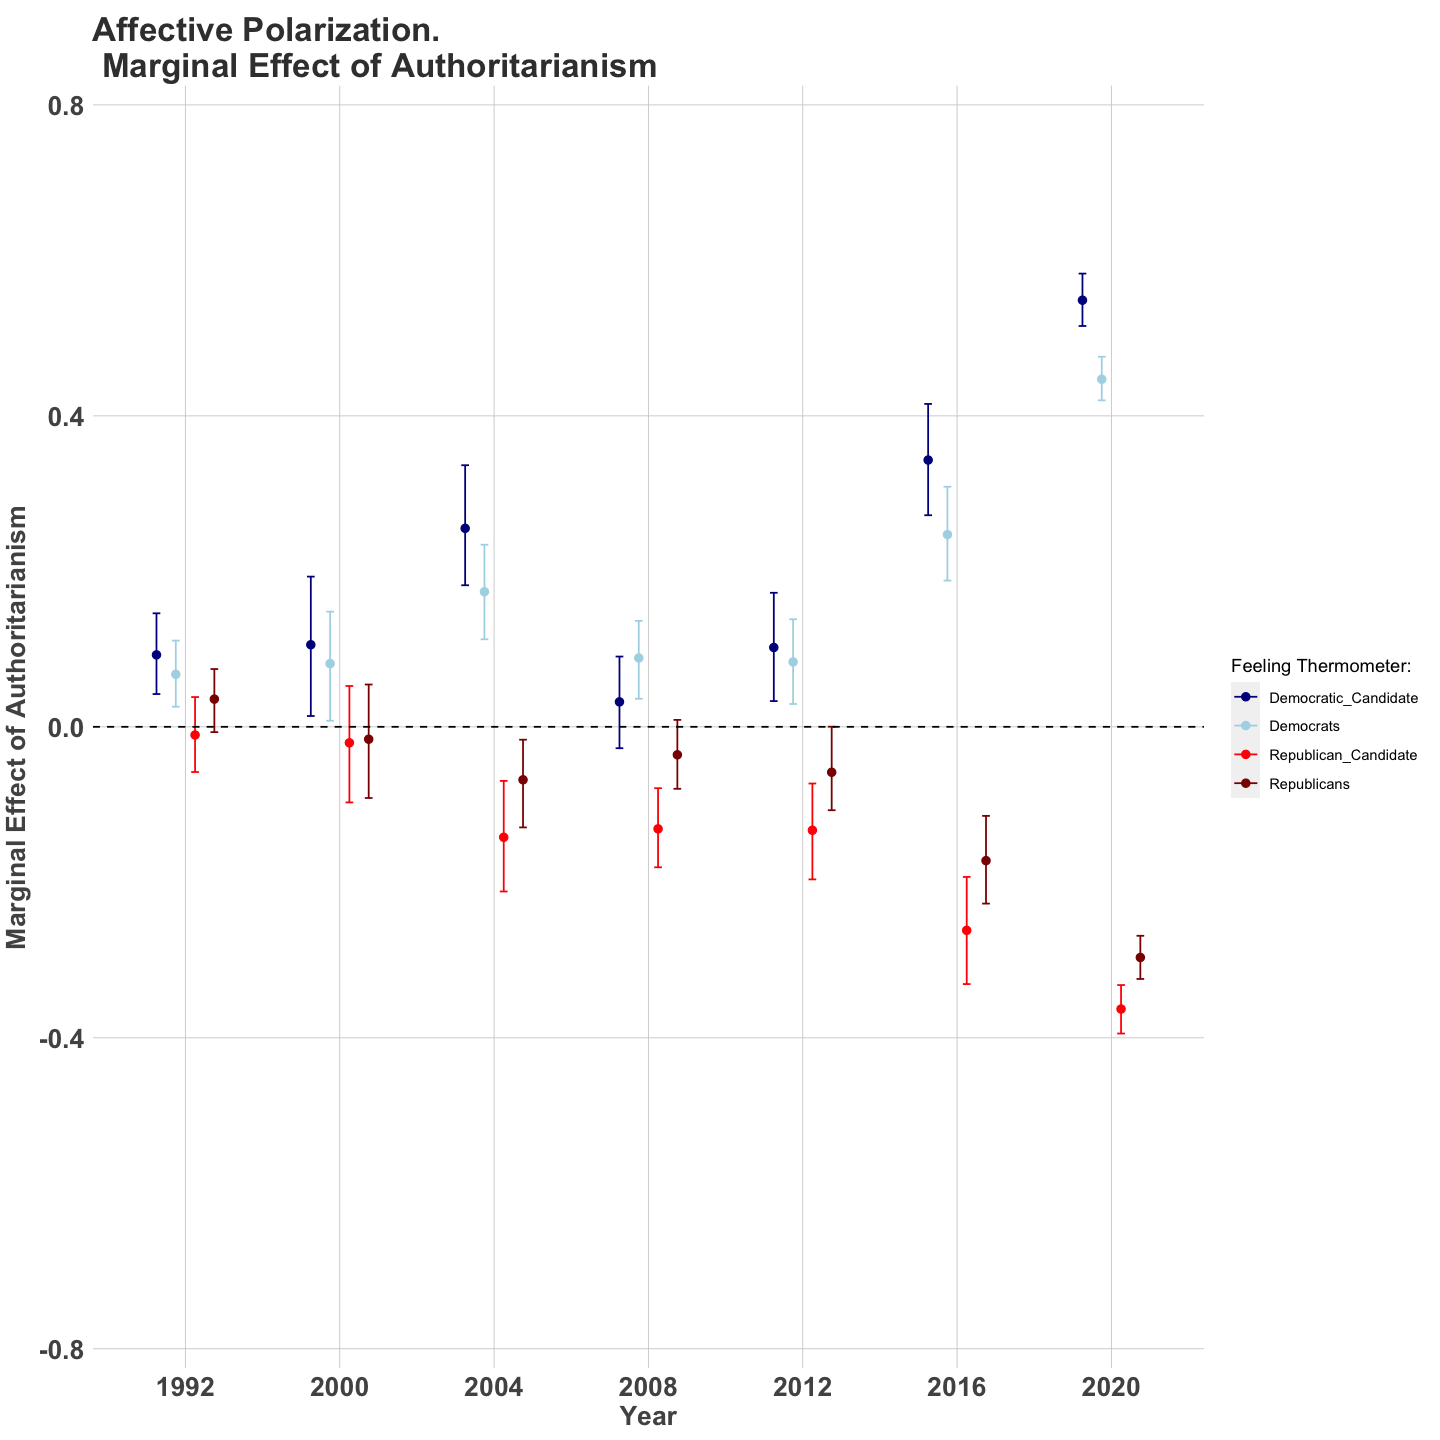

In [90]:
 options(repr.plot.width=12, repr.plot.height=12)

data.frame(rbind(
    margins(fixed_data, model_fit = reps) %>% group_by(year) %>%  summarise(mean = quantile(marginal, prob =0.5), 
                                                                            min  = quantile(marginal, prob =0.025), 
                                                                            max  = quantile(marginal, prob =0.975)) %>% mutate(Party = "Republicans"),

    margins(fixed_data, model_fit = dems) %>% group_by(year) %>%  summarise(mean = quantile(marginal, prob =0.5), 
                                                                            min  = quantile(marginal, prob =0.025), 
                                                                            max  = quantile(marginal, prob =0.975)) %>% mutate(Party = "Democrats"),
    margins(fixed_data, model_fit = repc) %>% group_by(year) %>%  summarise(mean = quantile(marginal, prob =0.5), 
                                                                            min  = quantile(marginal, prob =0.025), 
                                                                            max  = quantile(marginal, prob =0.975)) %>% mutate(Party = "Republican_Candidate"),
    margins(fixed_data, model_fit = demc) %>% group_by(year) %>%  summarise(mean = quantile(marginal, prob =0.5), 
                                                                            min  = quantile(marginal, prob =0.025), 
                                                                            max  = quantile(marginal, prob =0.975)) %>% mutate(Party = "Democratic_Candidate"))) %>%  
ggplot(aes(x = factor(year), 
                  y = mean, ymin=min, 
                  ymax=max, colour = as.factor(Party), group = as.factor(Party)))+
  geom_point(size=2,  alpha = 1, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.20, alpha=1, position = position_dodge(width = 0.5)) +
  ggtitle("Affective Polarization.\n Marginal Effect of Authoritarianism") +
  ggtheme + 
  scale_y_continuous("Marginal Effect of Authoritarianism", limits=c(-0.75,0.75)) + 
  scale_x_discrete("Year") + 
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") + 
  scale_colour_manual(name="Feeling Thermometer:", values=c("darkblue", "lightblue", "red", "darkred"))

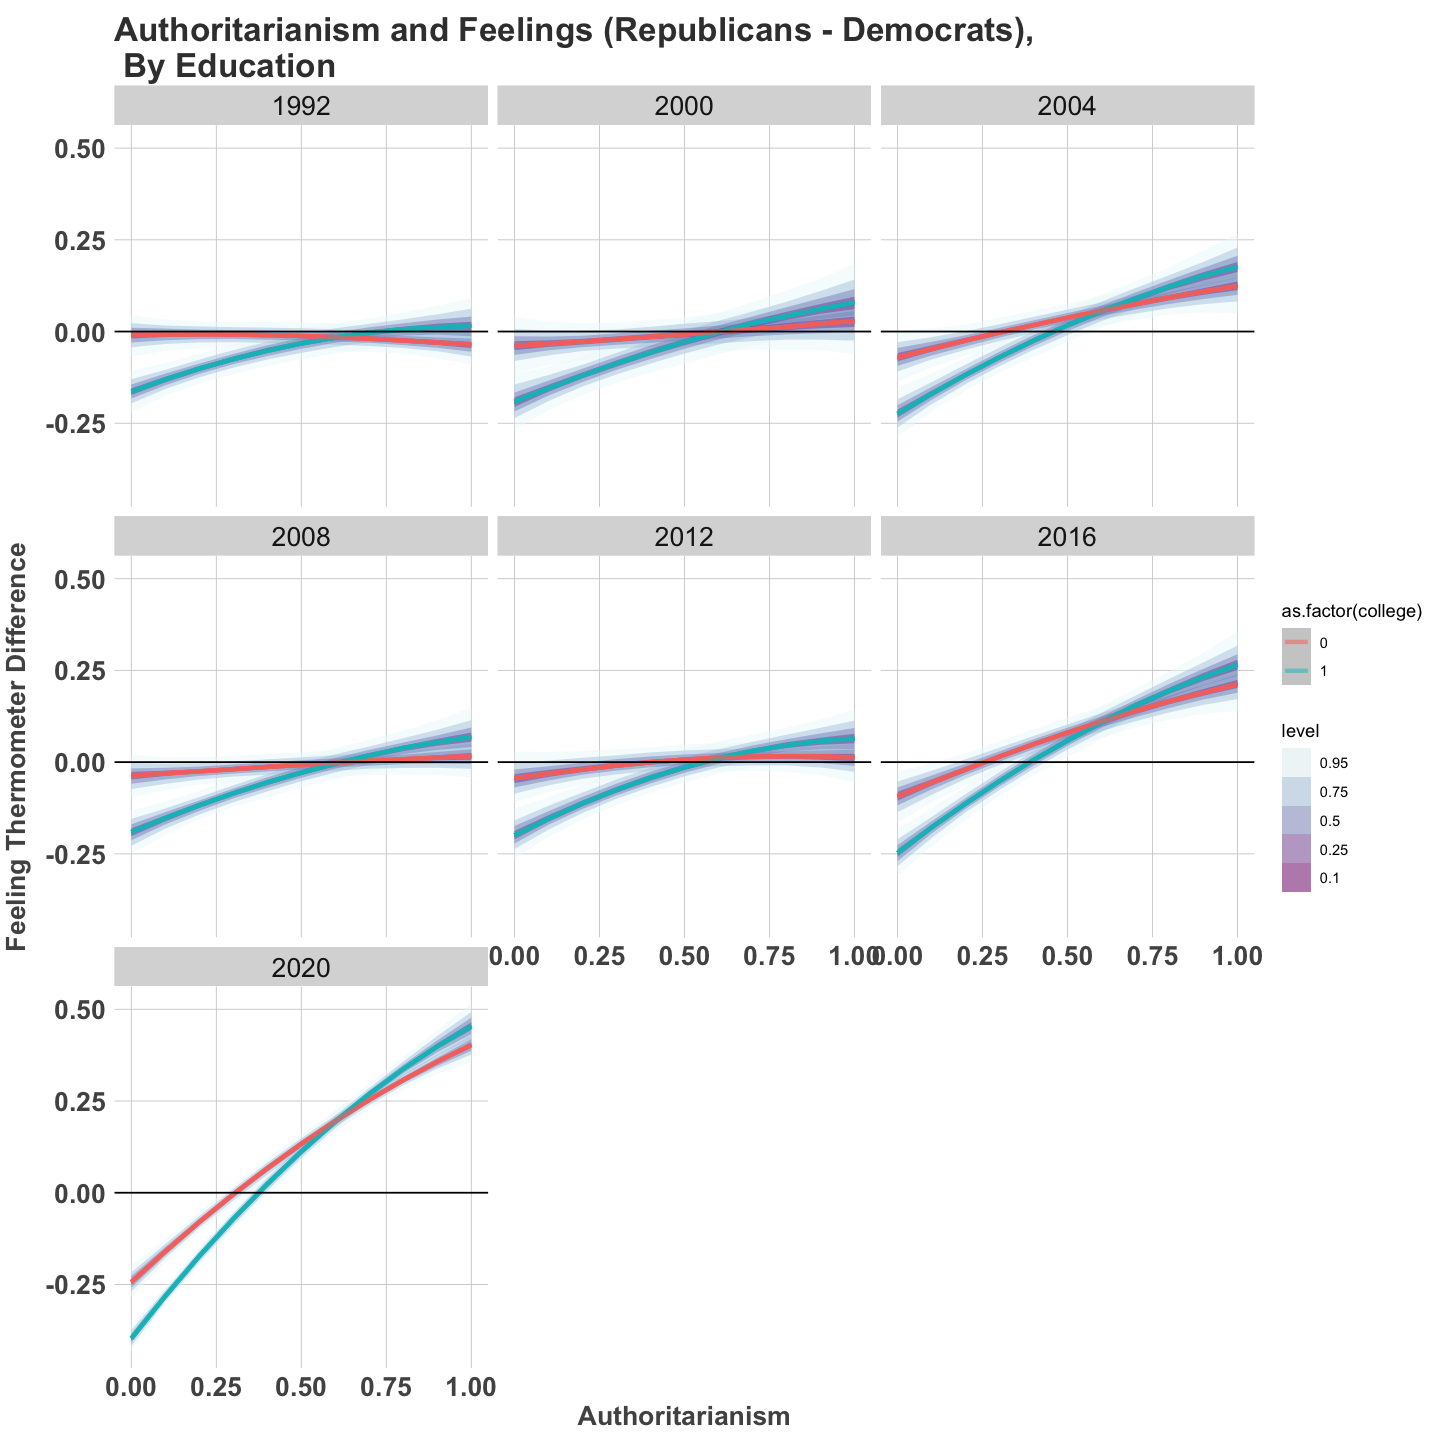

In [93]:
difference = affect[[5]]
fixed_data %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = c(0,1), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), 
                                                      authoritarianism = seq_range(authoritarianism, n = 11)) %>%   
                                                      mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%  
                                                      group_by(year) %>%
                                                      add_linpred_draws(difference) %>% 
                                                      mutate(Feeling = .linpred)  %>%  
     ggplot(aes(x = authoritarianism, group = college, colour = as.factor(college))) + facet_wrap(~year) + 
      stat_lineribbon(aes(y = Feeling), .width = c(.95, 0.75, .5, 0.25, 0.1),  alpha = 0.5) +
      scale_fill_brewer(palette = 3)+ ggtheme + geom_hline(yintercept = 0)+
  # Format the grid
  ggtitle("Authoritarianism and Feelings (Republicans - Democrats),\n By Education") +
  scale_y_continuous("Feeling Thermometer Difference")+
  scale_x_continuous("Authoritarianism")                                                        
                                           

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.


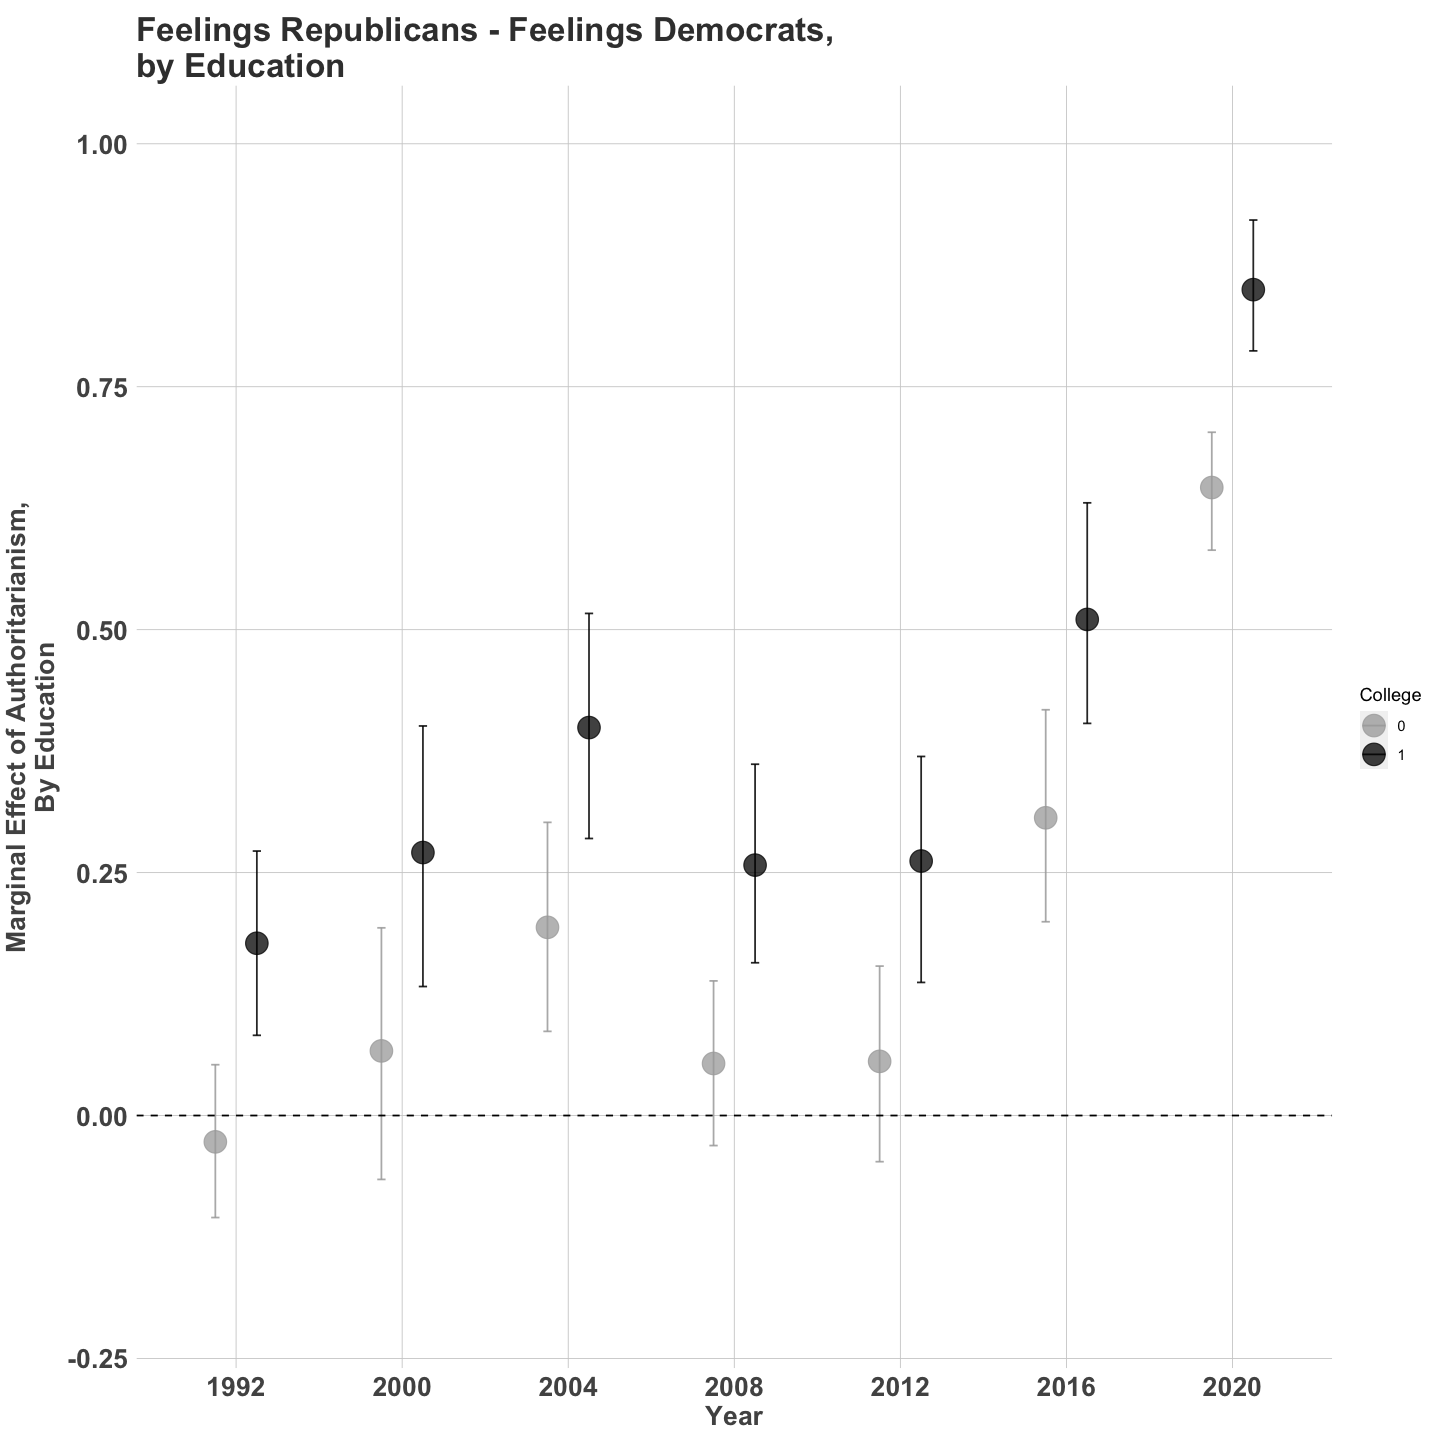

In [102]:
marginal_by_ed(fixed = fixed, model_fit = difference)  %>% group_by(year, college) %>% 
                                        mutate(min              = quantile(marginal, 0.025)) %>% 
                                        mutate(med              = quantile(marginal, 0.50)) %>% 
                                        mutate(max              = quantile(marginal, 0.975)) %>%   
                                        summarize(
                                            min = quantile(min, 0.025),
                                            med = quantile(med, 0.50),
                                            max = quantile(max, 0.975)) %>% 
ggplot(aes(x = factor(year), 
                  y = med, ymin=max, 
                  ymax=min, colour = as.factor(college), group = as.factor(college)))+
  geom_point(size=6,  alpha = 0.75, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.10, alpha=0.85, position = position_dodge(width = 0.5)) +
  ggtitle("Feelings Republicans - Feelings Democrats,\nby Education") +
  ggtheme + 
  scale_y_continuous("Marginal Effect of Authoritarianism,\nBy Education", limits=c(-0.2,1)) + 
  scale_x_discrete("Year") + 
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  scale_colour_manual(name="College", values=c("darkgrey", "black"))

Things do seem to change in 2016, 2020. There's really no effect of authoritarianism on affective polarization among non-college educated respondents before 2016

## Partisanship and Authoritarian Sorting

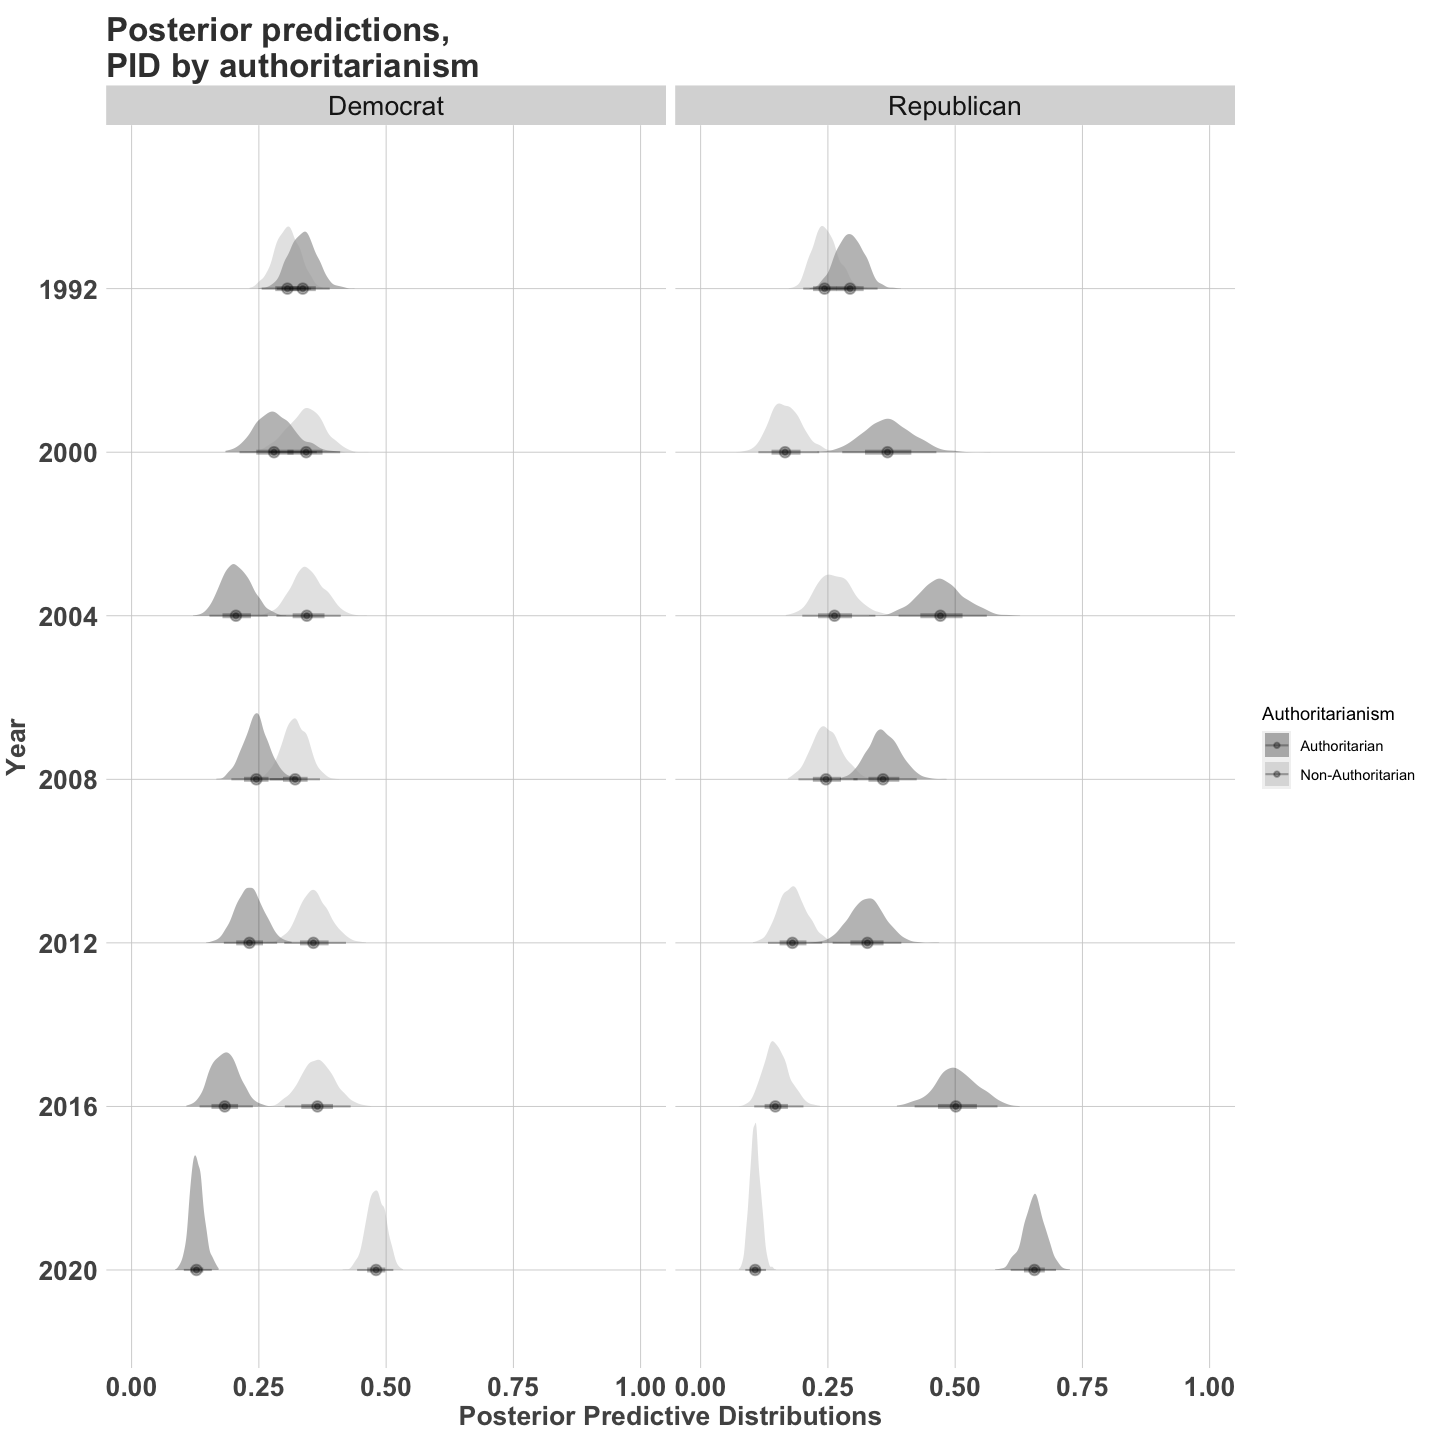

In [126]:
library(tidybayes)
party = party_model[[2]]
data[,c("party3", "authoritarianism", 
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit() %>% 
                 group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = mean(college), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), 
                                                      authoritarianism = seq_range(authoritarianism, n = 2)) %>%   
                                                      mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%  
                                                      group_by(year) %>%
                                                      add_epred_draws(party)  %>% 
                                                      mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                                                      mutate(PID = recode(.category, `1` = "Democrat", `2` = "Independent" , `3` = "Republican")) %>%

    subset(.category != 2) %>% 
    ggplot(aes(x = .epred, y = as.factor(year), 
                                                group = as.factor(authoritarianism),  fill = Authoritarianism)) +  facet_wrap(~PID) + 
                                                stat_halfeye(alpha =0.3) + ggtheme +
  # Format the grid
  ggtitle("Posterior predictions,\nPID by authoritarianism") +
  scale_x_continuous("Posterior Predictive Distributions", limits=c(0,1)) +
  scale_y_discrete("Year", limits = rev) +
  scale_fill_manual(name="Authoritarianism", values=c("black", "darkgrey"))

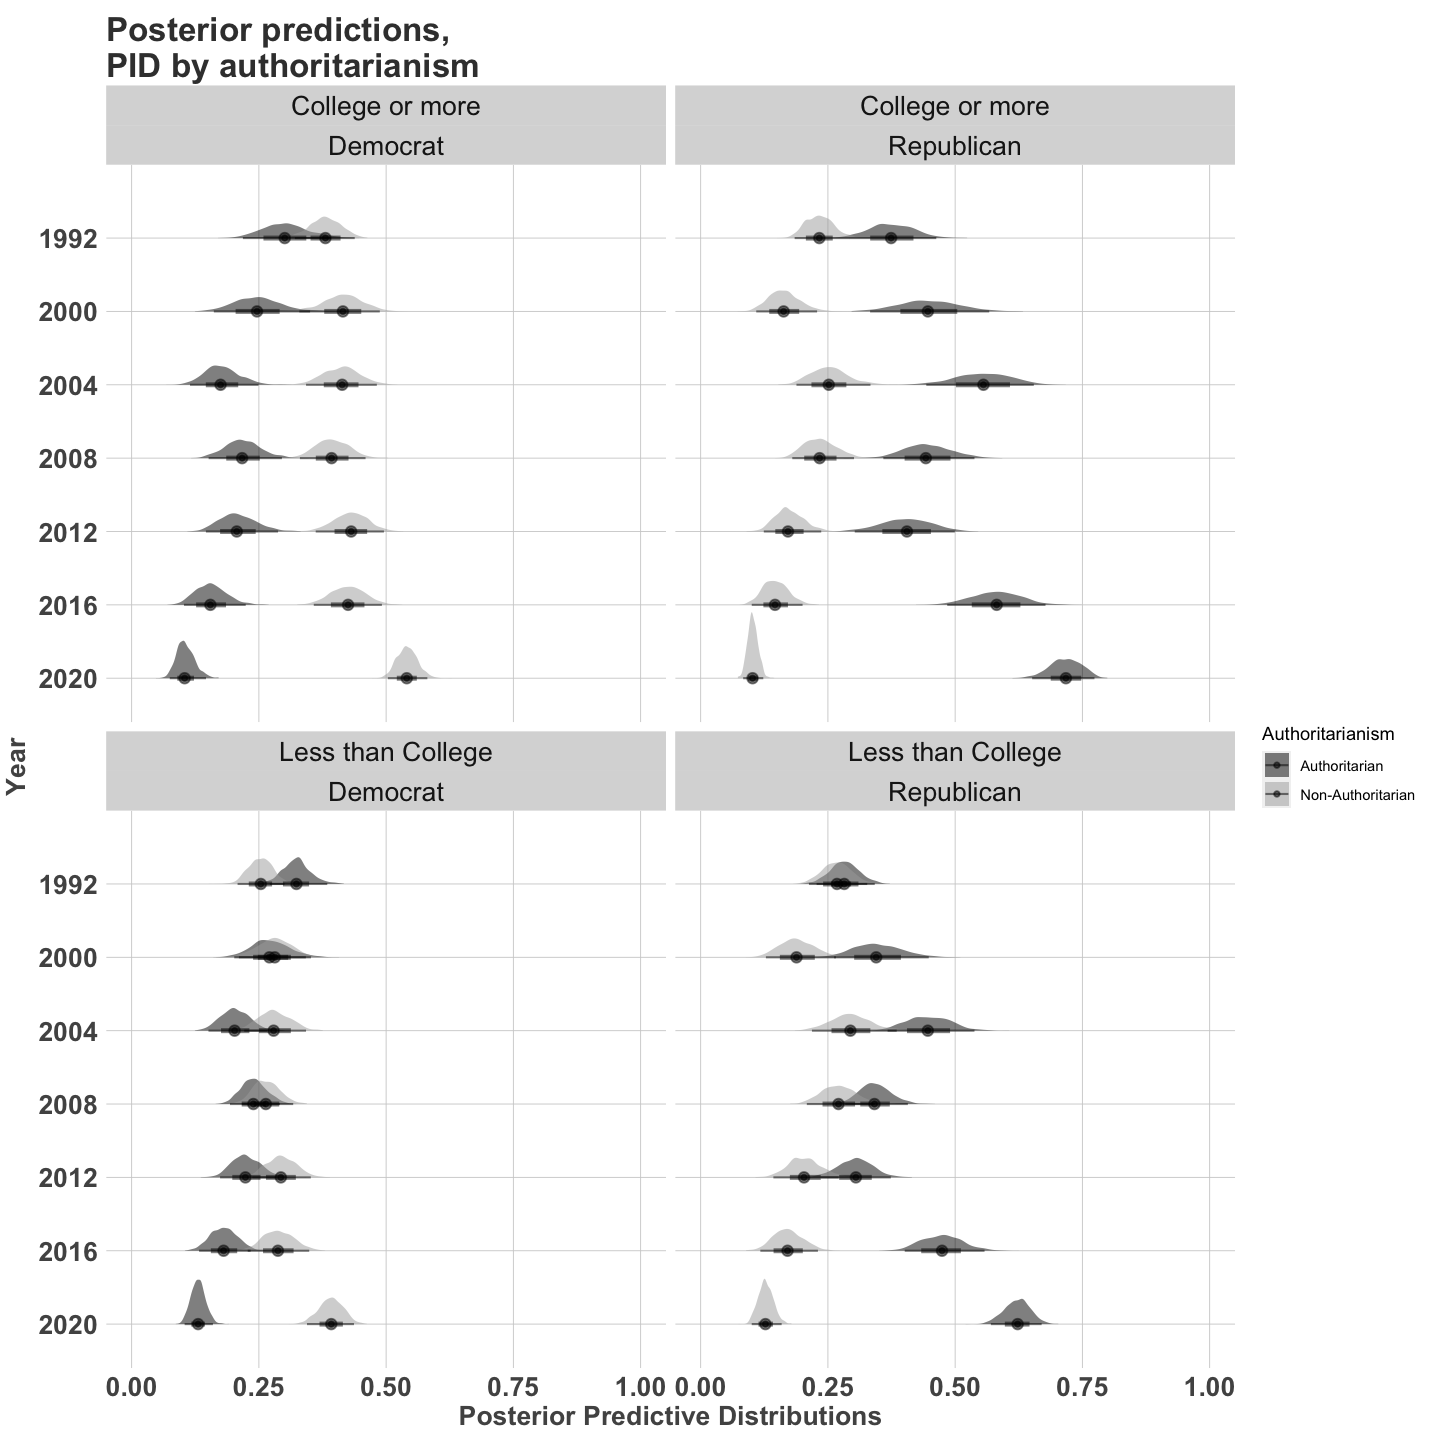

In [132]:
partyXed = party_model[[1]]
data[,c("party3", "authoritarianism", 
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit() %>% 
                 group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = c(0,1), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), 
                                                      authoritarianism = seq_range(authoritarianism, n = 2)) %>%   
                                                      mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%  
                                                      group_by(year) %>%
                                                      add_epred_draws(partyXed)  %>% 
                                                      mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                                                      mutate(PID = recode(.category, `1` = "Democrat", `2` = "Independent" , `3` = "Republican")) %>%
                                                      mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%


    subset(.category != 2) %>% 
    ggplot(aes(x = .epred, y = as.factor(year), 
                                                group = as.factor(authoritarianism),  fill = Authoritarianism)) +  
                                                facet_wrap(~Education+PID) + 
                                                stat_halfeye(alpha =0.5) + ggtheme +
  # Format the grid
  ggtitle("Posterior predictions,\nPID by authoritarianism") +
  scale_x_continuous("Posterior Predictive Distributions", limits=c(0,1)) +
  scale_y_discrete("Year", limits = rev) +
  scale_fill_manual(name="Authoritarianism", values=c("black", "darkgrey"))

The effect of authoritarianism among the on-college educated only begin to emerge in 2016. Here's another interesting graph. Authoritarianism has a relatively flat effect in 2012, 2008.


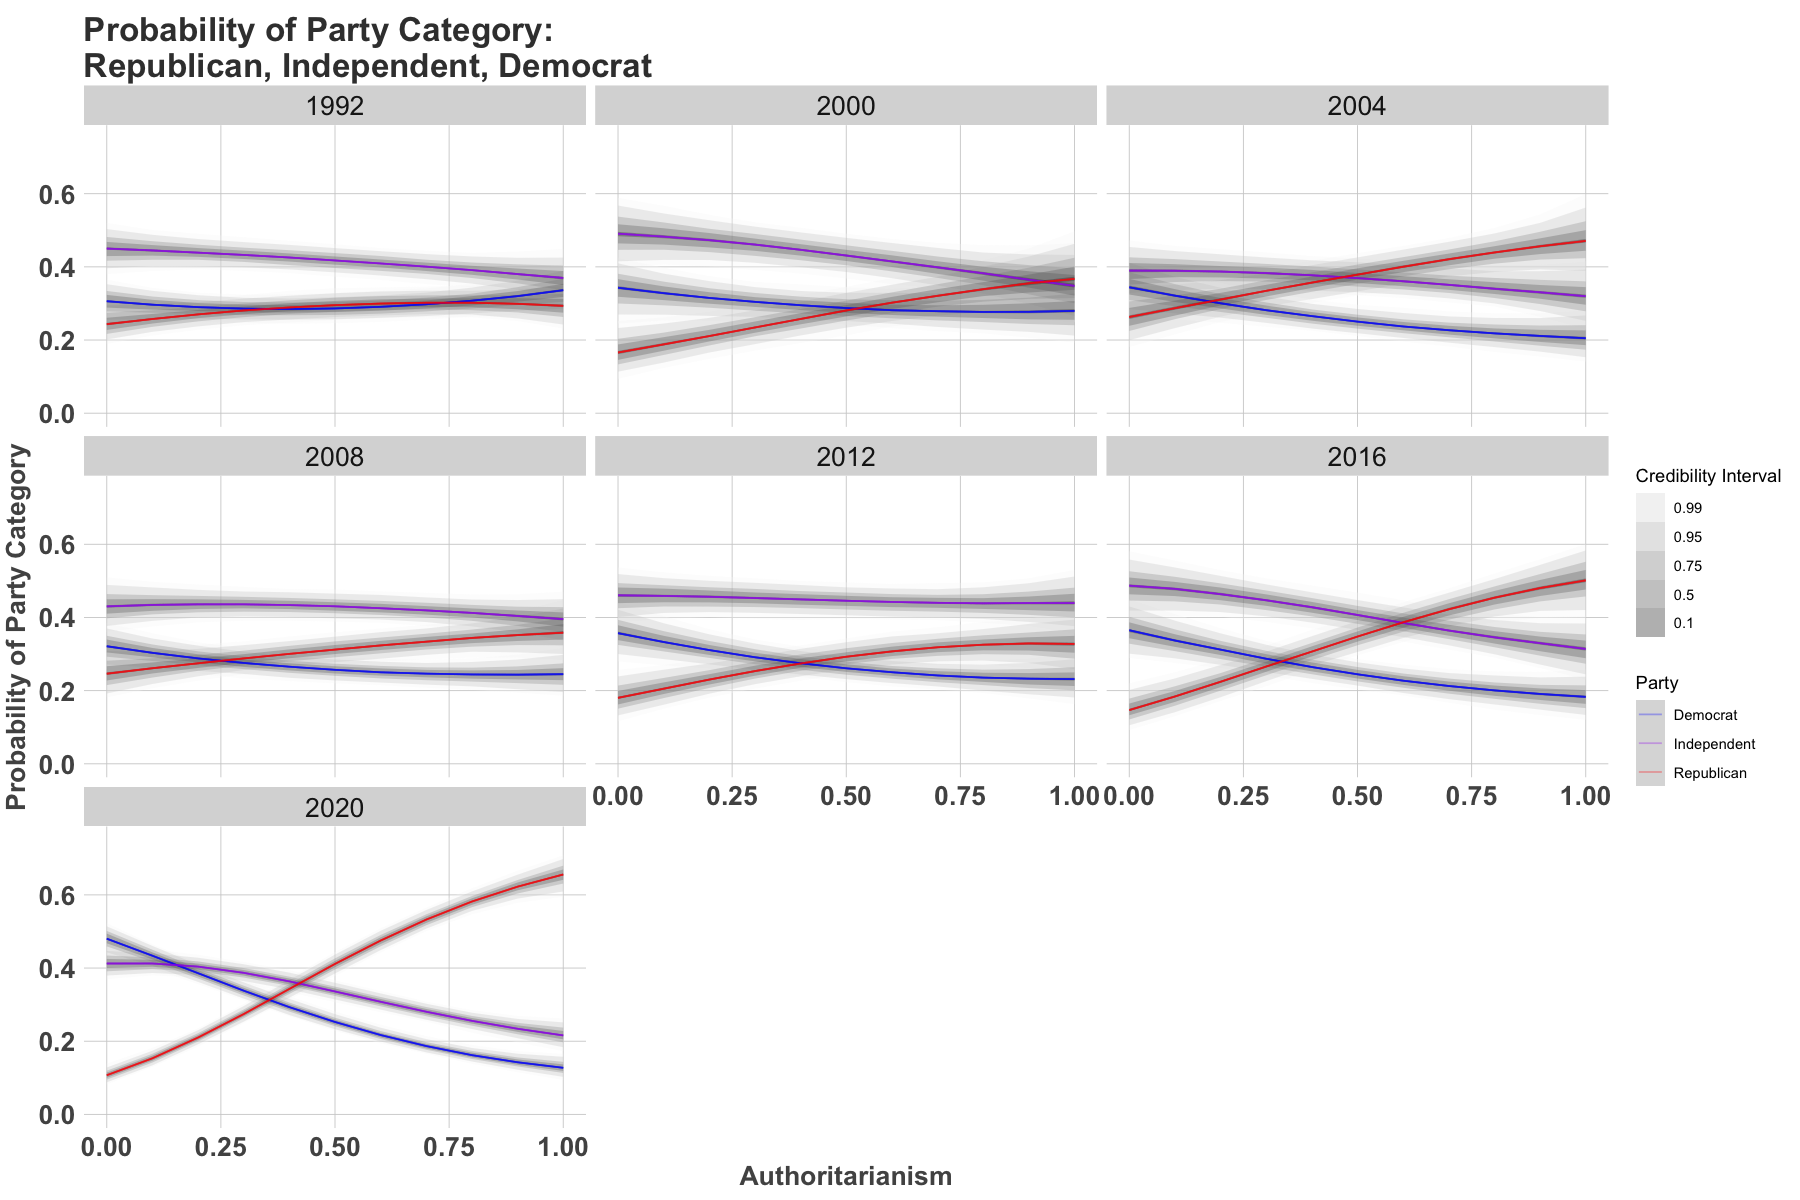

In [161]:
 options(repr.plot.width=15, repr.plot.height=10)

fixed_data %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = mean(college), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), 
                                                      authoritarianism = seq_range(authoritarianism, n = 11)) %>%   
                                                      mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%  
                                                      group_by(year) %>%
                                                      add_epred_draws(party)  %>%  
                                                      mutate(PID = recode(.category, `1` = "Democrat", `2` = "Independent", `3` = "Republican" ))  %>%  
                                               #       subset(.category != 2)  %>%
      ggplot(aes(x = authoritarianism, color = PID)) + facet_wrap(~year) + 
      stat_lineribbon(aes(y = .epred), .width = c(.1, .5, 0.75, 0.95, 0.99), size = 0.5,  alpha = 0.3) +
      scale_color_manual(name="Party",values = c("blue", "purple", "red"))+ ggtheme + 
      scale_fill_brewer(name="Credibility Interval", palette = "Greys")+ 

  # Format the grid
  ggtitle("Probability of Party Category:\nRepublican, Independent, Democrat") +
  scale_y_continuous("Probability of Party Category", limits=c(0,0.75))+
  scale_x_continuous("Authoritarianism")                                                        
                                                                        
     


Authoritarians clearly shift to the Republican Party, but really only in 2004, and then again in 2016, 2020.

# Mediation and Moderation

In [ ]:
        # Follow this super closely -- basically just name everythign. a
        data{
                int<lower=0> N;                           // number of observations
                int<lower=0> P;                           // number of columns in the control matrix. Call control the matrix of rhs variables minus pid and authoritarianism
                matrix[N, P] X;                           // controls, so excluding authoritariaism and pid
                vector[N]    A;                          // observed authoritarianism, again just extracting stuff from the data matrix
                vector[N]    A_2;                     
                int<lower=0,upper=1> M[N];               // observed pid
                int<lower=0,upper=1> MxA[N];             // observed pid
                int<lower=0,upper=1> MxA_2[N];           // observed pid
                int<lower=0,upper=1> Y[N];               // voting              
                vector[P + 4] alpha_m;                   // mean of regression priors.  Again, just declaring according to the 
                vector[P + 1] beta_m;                    // vector of priors for the mediation equation, PID = .....
                cov_matrix[P + 4] alpha_vcv;             // variance-covariance of regression priors
                cov_matrix[P + 1] beta_vcv;
                    }
        transformed data{
                vector[N] boot_probs = rep_vector(1.0/N, N);     // make vector of 1/N for (classical) bootstrapping. This just assigns an equal probability for bootstrap samples..
                vector[N] Mv   = to_vector(M);                  // make vector copy of M
                vector[N] MxAv = to_vector(MxA);                 // make vector copy of MxA
                vector[N] MxA_2v = to_vector(MxA_2);             // make vector copy of MxA_2
                }
        parameters{
                vector[P + 4] alpha;                         // regression coefficients (outcome model), add 2 because the size of this vector also include pid/auth ints included
                vector[P + 1] beta;                          // regression coefficients (mediator model), add 1 because must also include auth.
                }
        transformed parameters {
                //Save all the parameters in a set of vectors; alpha for the outcome, beta for the mediation
                vector[P] betaZ       = head(beta, P);                 
                vector[P] alphaZ      = head(alpha, P);                
                real betaA            = beta[P + 1];               
                real betaA_2          = beta[P + 2];                 
                real alphaA           = alpha[P + 1];    
                real alphaA_2         = alpha[P + 2];        
                real alphaM           = alpha[P + 3];                
                real alphaMxA         = alpha[P + 4];                             
                real alphaMxA_2       = alpha[P + 5];                             

            }

            ### Fix the model...
        model {
            alpha ~ multi_normal(alpha_m, alpha_vcv);                   // priors on causal coefficients weakly informative for binary exposure
            beta  ~ multi_normal(beta_m, beta_vcv);
            M ~ bernoulli_logit(X * betaZ +  A * betaA);                     // likelihood for the pid model. The indexing is just to extract stuff later.
            Y ~ bernoulli_logit(X * alphaZ + A * alphaA + Mv * alphaM + MxAv * alpha);      // likelihood in the voting model
            }
        generated quantities {
            int row_i;                                                   // row index to be sampled for bootstrap
            real PNDE = 0;                                               // calculate pure NDE in the bootstrapped sample
            real TNDE = 0;                                               // calculate total NDE in the bootstrapped sample
            vector[N] M_a0;
            vector[N] M_a1;

            vector[N] Y_a1Ma0;                                          //store the treatment effect when mediator is 0
            vector[N] Y_a0Ma0;


            vector[N] Y_a1Ma1;                                          //store the treatment effect when mediator is 0
            vector[N] Y_a0Ma1;

            for (n in 1:N) {
                row_i   = categorical_rng(boot_probs);            // sample index based on the boot_prob calculation above.
                M_a0[n] = bernoulli_logit_rng(X[row_i] * betaZ);  // sample from  Ma where a = 0; basically, lets calculate the value when auth = 0. 
                M_a1[n] = bernoulli_logit_rng(X[row_i] * betaZ + A[row_i]*betaA);  // sample from  Ma where a = 1; basically, lets calculate the value when auth = 1. 
            // This draw creates a 0/1 realization. Feed that into the outcome equation
                Y_a1Ma0[n] = bernoulli_logit_rng(X[row_i] * alphaZ + M_a0[n] * alphaM + alphaA); // sample Y_(a=1, M=M_0) and Y_(a=0, M=M_0)
                Y_a0Ma0[n] = bernoulli_logit_rng(X[row_i] * alphaZ + M_a0[n] * alphaM ); // sample Y_(a=1, M=M_0) and Y_(a=0, M=M_0)
                Y_a0Ma1[n] = bernoulli_logit_rng(X[row_i] * alphaZ + M_a1[n] * alphaM); // sample Y_(a=1, M=M_0) and Y_(a=0, M=M_0)


Y_a0Ma0[n] = bernoulli_logit_rng(X[row_i] * alphaZ + M_a0[n] * alphaM); // add contribution of this observation to the bootstrapped NDE

PNDE = NDE + (Y_a1Ma0[n] - Y_a0Ma0[n])/N;
TNDE = NDE + (Y_a1Ma0[n] - Y_a0Ma0[n])/N;
PIE  = PIE + (Y_a0Ma1[n] - Y_a0Ma0[n])/N;


Pure: Y0M1-Y0M0
}

In [169]:
# 1) Posterior PID, Auth = 0, Auth =1
# 2) Posterior Vote, Authoritarianism x PID (in model and predictions)
# 3) Calculate the NDE, NIE, from these predictions.

library(tidybayes)
party = party_model[[2]]
m0 = data[,c("party3", "authoritarianism", 
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit() %>% 
                 group_by(year) %>% 
                 mutate(authoritarianism = 0) %>% 
                 mutate(authoritarianism_2 = authoritarianism^2) %>% 
                 add_epred_draws(party) ### Party Identification, mediator variable, auth = 0
                 
m1 = data[,c("party3", "authoritarianism", 
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit() %>% 
                 group_by(year) %>% 
                 mutate(authoritarianism = 0) %>% 
                 mutate(authoritarianism_2 = authoritarianism^2) %>% 
                 add_epred_draws(party) ### Party Identification, mediator variable, auth = 1
## Outcome Equation                 


                 

In [170]:
tst

party3,authoritarianism,female,age,college,income,jewish,catholic,other,year,authoritarianism_2,.row,.chain,.iteration,.draw,.category,.epred
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<fct>,<dbl>
2,0,0,0.4,0,1,0,0,0,2000,0,1,NA,NA,1,1,0.2160112
2,0,0,0.4,0,1,0,0,0,2000,0,1,NA,NA,2,1,0.2296439
2,0,0,0.4,0,1,0,0,0,2000,0,1,NA,NA,3,1,0.2061403
2,0,0,0.4,0,1,0,0,0,2000,0,1,NA,NA,4,1,0.2311276
2,0,0,0.4,0,1,0,0,0,2000,0,1,NA,NA,5,1,0.1962115
2,0,0,0.4,0,1,0,0,0,2000,0,1,NA,NA,6,1,0.2554561
2,0,0,0.4,0,1,0,0,0,2000,0,1,NA,NA,7,1,0.1600742
2,0,0,0.4,0,1,0,0,0,2000,0,1,NA,NA,8,1,0.2065684
2,0,0,0.4,0,1,0,0,0,2000,0,1,NA,NA,9,1,0.2164264
